In [ ]:
#----------------------------------------------------------------------------
# IMPORTANDO BIBLIOTECAS
#----------------------------------------------------------------------------

import pandas as pd
from tabulate import tabulate

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

import string
import gc       # gc.collect() to free memory

In [ ]:
#------------------------------------------------------------------------------------------------
# MÉTODO PARA CONFIGURAR AS FONTES DE UM GRÁFICO COM BASE NOS VALORES PADRONIZADOS 
#------------------------------------------------------------------------------------------------
# Valores padronizados para tamanho de fontes em gráficos
SMALL_SIZE = 16
MEDIUM_SIZE = 24
BIGGER_SIZE = 30
def set_fontsizes_in_plot():
    plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
set_fontsizes_in_plot()

<a name="02"></a>
### Compilação dos Microdados 2015-2019

A seguir, crio listas agrupando colunas de interesse para compilar os microdados em um novo dataset.  
Também crio variáveis auxiliares relacionadas aos microdados.

In [ ]:
#----------------------------------------------------------------------------
# AGRUPANDO RÓTULOS DAS COLUNAS DE INTERESSE
#----------------------------------------------------------------------------

notas_provas_str = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO']
presenca         = ['TP_PRESENCA_CN','TP_PRESENCA_CH','TP_PRESENCA_LC','TP_PRESENCA_MT']
identidade       = ['NU_IDADE','TP_COR_RACA','TP_NACIONALIDADE']
socioeconomicos  = ['Q001','Q002','Q003','Q004','Q005','Q006']
genero           = ['TP_SEXO', 'IN_GESTANTE','IN_LACTANTE']
geografico       = ['SG_UF_RESIDENCIA',]
educacao         = ['TP_ESCOLA','TP_DEPENDENCIA_ADM_ESC','TP_ST_CONCLUSAO','TP_ENSINO']
outros           = ['TP_LINGUA','TP_STATUS_REDACAO','IN_TREINEIRO']
cols_to_use = notas_provas_str + presenca + identidade + socioeconomicos + genero + geografico + outros + educacao

#------------------------------------------------------------------------------------------------
# ESQUEMA DE CORES PERSONALIZADO PARA DADOS DE COR/RAÇA (PALETTE DO SEABORN)
#------------------------------------------------------------------------------------------------
colors = np.array(
        [(255,0,0),    # unknown
         (200,200,200), # branco
        (0,0,0),        # preto
        (150,75,0),     # pardo
        (243,229,99),  # amarelo
        (0,123,165)]    # indig.
        )/255
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))

#------------------------------------------------------------------------------------------------
# VARIÁVEIS AUXILIARES PARA REALIZAR MUDANÇAS DE RÓTULO EM DADOS CATEGÓRICOS DE ALGUNAS COLUNAS 
#------------------------------------------------------------------------------------------------

dict_tipo_escola = {1:'N/A',2:"Pública",3:"Privada",4:"Exterior"}
dict_adm_escola = {1:'Federal',2:'Estadual',3:'Municipal',4:'Privada'}
dict_cor_raca = {0:'N/A', 1:'Branca', 2:'Preta', 3:'Parda', 4:'Amarela', 5:'Indígena', 6:'N/A'}
dict_provas = {'NU_NOTA_CN':"Ciências da Natureza", 'NU_NOTA_CH':"Ciências Humanas", 
               'NU_NOTA_LC':"Línguagens e Códigos", 'NU_NOTA_MT':"Matemática", 'NU_NOTA_REDACAO':"Redação"}

lista_A_to_Q = [chr(i) for i in range(ord('A'),ord('Q')+1)] # CATEGORIAS DE RENDA A-Q

Para compilar os microdados dos _datasets_ de 2015 a 2019, elaborei algumas funções auxiliares.  
A ideia geral é criar um dicionário de DataFrames, cuja chave é o ano correspondente dos microdados.  
Durante a importação, são selecionadas apenas as colunas de interesse, e também eliminando alguns dados para restringir o espaço amostral. 

In [ ]:
#-------------------------------------------------------------------------------------------
# FUNÇÕES AUXILIARES PARA COMPILAR OS MICRODADOS DO ENEM 2015 ATÉ 2019 EM UM NOVO DATASET
#-------------------------------------------------------------------------------------------

def cria_entrada_para_ano(ano=2019, nota_soma=True, ausentes=True, estrangeiros=True, treineiros=True, sep=';'):
    ''' Carrega os microdados do ano especificado. 
        Remove algumas entradas (estudantes ausentes, estrangeiros e trineiros). 
        Adiciona colunas de "nota_soma" e ano.
        Retorna o conjunto de dados resultante.
    '''
    print(f'Trabalhando no ano {ano} [...]')
    D = pd.read_csv('./data/'+ str(ano) + '/MICRODADOS_ENEM_'+ str(ano) + '.csv', 
                             encoding='ISO-8859-1', sep=sep ,usecols=cols_to_use)
    D = clean_df(D,ausentes=ausentes,estrangeiros=estrangeiros,treineiros=treineiros)
    D = adiciona_colunas(D, ano=ano, nota_soma=nota_soma)
    return D

def clean_df(df, ausentes=True, estrangeiros=True, treineiros=True):
    '''Remove algumas entradas (estudantes ausentes, estrangeiros e trineiros) e retorna os dados restantes.
    '''
    print(f'Tamanho inicial: {len(df)}')
    if ausentes: # remover que faltou uma das provas
        query_presenca_total = 'TP_PRESENCA_CN==1 and TP_PRESENCA_CH==1 and TP_PRESENCA_LC ==1 and TP_PRESENCA_MT==1'
        df = df.query(query_presenca_total).drop(presenca,axis=1)
        print(f"Após remover ausentes: {len(df)}")
    if estrangeiros: # remover estrangeiros
        query_nao_estrangeiro = 'TP_NACIONALIDADE != 3' # diferente de estrangeiro
        df = df.query(query_nao_estrangeiro)
        print(f"Após remover estrangeiros: {len(df)}")
    if treineiros: # Remover Treineiros
        df = df.query('IN_TREINEIRO == 0').drop('IN_TREINEIRO',axis=1)
        print(f"Após remover treineiros: {len(df)}")
    return df

def adiciona_colunas(df, ano=None, nota_soma=True):
    '''Adiciona colunas de "nota_soma" e ano.
    '''
    if ano:
        df['Ano'] = ano
    if nota_soma:
        df['nota_soma'] = df[notas_provas_str].sum(axis=1)
    return df

Abaixo, a variável ```load_input``` permite que você apenas carregue os microdados compilados no diretório  
```./outputs/ENEM_dados_selecionados_2015-2019.csv```.  

Caso queira gerar a base novamente a partir dos dados originais, mude ```load_input``` para ```False```. <br>  
Note que o código assume que você já extraiu os microdados dos anos de interesse no diretório ```./data/<ANO>//MICRODADOS_ENEM_<ANO>.csv```. <br>  
Cuidado também com o tipo de separador (nos microdados de 2015, usa-se ```,```, enquanto nos demais usa-se ```;```.  <br>
Antes de 2015, os dados possuem muita inconsistência na estrutura e nome das variáveis, por isso não utilizei os anos anteriores.

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# COMPILAR OS MICRODADOS DO ENEM 2015 ATÉ 2019 EM UM NOVO DATASET OU CARREGAR ARQUIVO DO DATASET PRÉ-COMPILADO
#--------------------------------------------------------------------------------------------------------------

load_input     = True # TRUE para carregar arquivo pré-combilado; FALSE para compilar a partir dos Microdados 2015-2019
overwrite_file = True # em caso de compilação, substituir arquivo existente 

if load_input: # CARREGANDO ARQUIVO PRÉ-COMPILADO
    cols_to_use = [i for i in cols_to_use if i not in ['IN_TREINEIRO']+presenca ] # remove colunas de treineiro e presença
    cols_to_use = cols_to_use + ['Ano', 'nota_soma']                              # acrescenta colunas de 'ano' e 'nota_soma' na lista para carregar
    # Carrega o Dataset de Microdados compilados 2015-2019 
    df0 = pd.read_csv('./outputs/ENEM_dados_selecionados_2015-2019.csv', encoding='utf-8', sep=';' ,usecols=cols_to_use)
    print(f'Tamanho do dataset: {len(df0)} linhas x {len(df0.columns)} colunas')
    gc.collect()
else:          # COMPILANDO A PARTIR DOS MICRODADOS 2015-2019
    
    # Cria um dicionário de DataFrames
    dict_dfs = {}
    for ano in range(2015,2020):
        sep = ',' if ano==2015 else ';'
        dict_dfs[ano] = cria_entrada_para_ano(ano=ano,sep=sep)
        gc.collect()

    # Concatena verticalmente os dados do dicionário de DataFrames
    df0 = dict_dfs[2015]
    for ano in range(2016,2020):
        df0 = df0.append(dict_dfs[ano])
        dict_dfs[ano] = None
        gc.collect()
    df0 = df0.reset_index()
    gc.collect()
        
    if overwrite_file:
        df0.to_csv('./outputs/ENEM_dados_selecionados_2015-2019.csv', index = False, encoding='utf-8',sep=';')
        
    ''' ÚLTIMO LOG: 
    Trabalhando no ano 2015 [...]
    Tamanho inicial: 7746427
    Após remover ausentes: 5604905
    Após remover estrangeiros: 5598341
    Após remover treineiros: 4826953
    
    Trabalhando no ano 2016 [...]
    Tamanho inicial: 8627367
    Após remover ausentes: 5818446
    Após remover estrangeiros: 5811857
    Após remover treineiros: 4972072
    
    Trabalhando no ano 2017 [...]
    Tamanho inicial: 6731341
    Após remover ausentes: 4426755
    Após remover estrangeiros: 4421297
    Após remover treineiros: 3985803
    
    Trabalhando no ano 2018 [...]
    Tamanho inicial: 5513747
    Após remover ausentes: 3893743
    Após remover estrangeiros: 3888944
    Após remover treineiros: 3430559
    
    Trabalhando no ano 2019 [...]
    Tamanho inicial: 5095270
    Após remover ausentes: 3702008
    Após remover estrangeiros: 3697792
    Após remover treineiros: 3170619
    '''

Tamanho do dataset: 20386006 linhas x 26 colunas


In [ ]:
df0.sample(10) # mostra uma sample do DataFrame

,SG_UF_RESIDENCIA,TP_DEPENDENCIA_ADM_ESC,NU_IDADE,TP_SEXO,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ESCOLA,TP_ENSINO,TP_COR_RACA,IN_GESTANTE,...,TP_STATUS_REDACAO,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Ano,nota_soma
7165178,DF,2.0,18.0,F,1,2,2,1.0,3,0,...,1.0,440.0,C,D,B,B,5.0,D,2016,2149.9
20286889,PR,NaN,22.0,F,1,1,1,NaN,1,0,...,1.0,660.0,F,G,F,D,4.0,L,2019,2990.5
14571614,CE,NaN,21.0,M,1,1,1,1.0,3,0,...,1.0,660.0,A,B,A,A,5.0,B,2018,2471.4
14683301,RN,2.0,17.0,M,1,2,2,1.0,2,0,...,1.0,700.0,B,B,C,C,2.0,C,2018,2979.1
7859973,SP,4.0,18.0,F,1,2,3,1.0,3,0,...,1.0,560.0,D,D,C,B,4.0,F,2016,2492.6
3303185,SC,2.0,17.0,F,1,2,2,1.0,1,0,...,1.0,640.0,D,C,C,B,6.0,F,2015,2904.7
703941,SP,4.0,17.0,M,1,2,3,1.0,1,0,...,1.0,580.0,G,F,E,E,4.0,P,2015,3079.9
2459589,GO,NaN,46.0,F,1,1,1,NaN,3,0,...,1.0,360.0,A,C,A,B,3.0,E,2015,1904.4
12420908,MA,NaN,18.0,M,1,1,1,NaN,3,0,...,1.0,340.0,C,E,A,A,5.0,B,2017,2004.9
11830299,MA,NaN,32.0,F,1,1,1,NaN,3,0,...,1.0,560.0,D,B,F,B,3.0,B,2017,2807.7


In [ ]:
print(df0.columns) # Mostra as Colunas do DataFrame

Index(['SG_UF_RESIDENCIA', 'TP_DEPENDENCIA_ADM_ESC', 'NU_IDADE', 'TP_SEXO',
       'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'TP_ENSINO',
       'TP_COR_RACA', 'IN_GESTANTE', 'IN_LACTANTE', 'NU_NOTA_CN', 'NU_NOTA_CH',
       'NU_NOTA_LC', 'NU_NOTA_MT', 'TP_LINGUA', 'TP_STATUS_REDACAO',
       'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006',
       'Ano', 'nota_soma'],
      dtype='object')


<a name="1"></a>
## 1. O que a prova do ENEM avalia? 

A prova do ENEM busca medir o grau de conhecimento dos estudantes brasileiros em diferentes áreas do conhecimento.  <br>
A prova se divide nas seguintes categorias:
- Ciências da Natureza
- Ciências Humanas
- Linguagens e Códigos
- Matemática
- Redação.

Como será que os brasileiros têm se saído nessa avaliação?  <br>
O que eles acertam mais?  <br>
É claro que é muito difícil avaliar isso de forma reducionista. Cada área de conhecimento utiliza diversas habilidades, e as tendências de nota em cada uma delas podem ter comportamentos diferentes, assim como o grau de exigência das pessoas que elaboram as questões pode mudar entre as duas áreas.  <br>
A prova de redação, por exemplo, avalia um conjunto de habilidades que para os mais leigos pode parecer bastante subjetivo. <br>

Mesmo com esse _disclaimer_, vamos comparar as notas em cada área de conhecimento ao longo dos anos, só pra ter uma ideia. :)

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# QUERY AND PROCESS
#--------------------------------------------------------------------------------------------------------------

df_notas = pd.DataFrame([],columns=['NOTA','Label'])
for nota_str in notas_provas_str:
    df_temp = pd.concat([df0[nota_str],pd.Series([nota_str]*len(df0)),df0['Ano']],axis=1).rename(columns={nota_str:'NOTA',0:'Label'})
    df_notas = pd.concat([df_notas,df_temp])
df_notas = df_notas.reset_index(drop=True)
df_notas['Label'] = df_notas['Label'].replace(dict_provas)

No gráfico abaixo, estamos vendo uma sequência de boxplots, 5 por ano, sendo cada um correspondente à distribuição das notas dos estudantes uma área do conhecimento diferente. <br>
Podemos observar algumas curiosidades:
- as notas de redação costumam ser bem altas, em média,  entretanto a sua dispersão é enorme, chegando a variar de 0 a 1000 em qusae todos os anos!
- a mediana (ponto que separa metade dos candidatos) das notas em ciências humanas costumava ser mais alta que as outras até 2019, onde a mediana de linguagens e códigos ultrapassou ela
- matemática possui muitos _outliers_ (casos pontuais, com baixíssima chance de acontecer) que chegam em notas altíssimas!
- todas as áreas possuem um grupo de _outliers_ na nota zero (mas lembre que já filtramos por alunos presentes em todas as provas!).

354

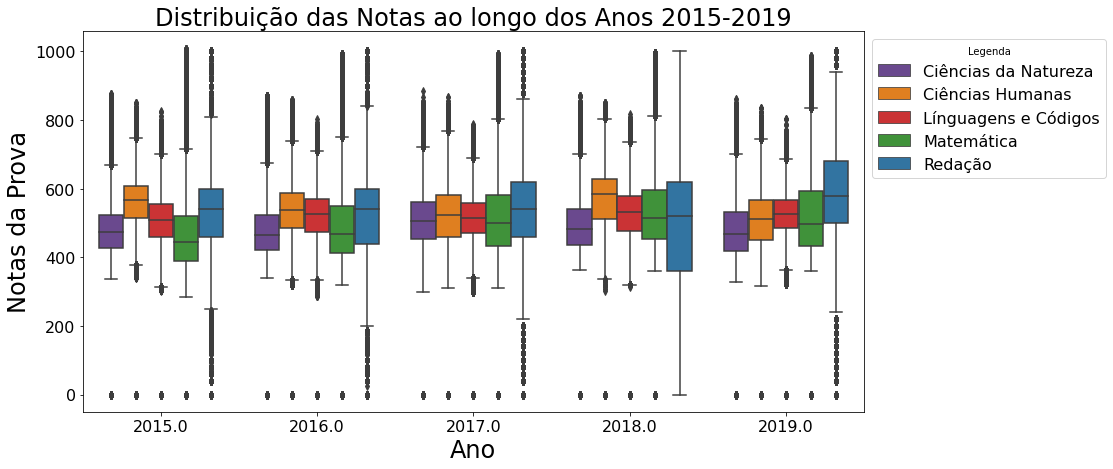

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# PLOT DATA
#--------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(14,7))

sns.boxplot(x='Ano',y='NOTA',hue='Label',data=df_notas,palette='Paired_r')

plt.legend(title='Legenda', bbox_to_anchor=(1, 1), loc='upper left',prop={'size': 16})
plt.title(f'Distribuição das Notas ao longo dos Anos 2015-2019')
plt.ylabel(f'Notas da Prova')
plt.xlabel('Ano')

# DUMP DATAFRAME TO FREE MEMORY
df_notas= None
df_temp = None
gc.collect()

Nas próximas análise, vou considerar uma nota que denominei ```nota_soma``` do candidato.  
Essa nota corresponde à soma de todas as notas do candidato nessas 5 avaliações.  
Vou utilizar essa medida para comparar o desempenho dos candidados de acordo com diversas outras variáveis.

<a name="2"></a>
## 2. A nota média dos estudantes de acordo com as UFs de residência

Sabemos que o Brasil é um país com dimensões geográficas continentais.  
Além da diversidade cultural, também é senso comum do imaginário do brasileiro que existem desigualdades econômicas e sociais entre regiões e estados do país.  
Será que os dados do ENEM revelam isso?

<a name="21"></a>
### UFs com maior e menor nota ao longo do anos

De onde são os estudantes com as maiores notas do ENEM?  
E os estudantes com as menores notas?  
Será que essa competição varia ao longo dos anos, igual ao campeonato brasileiro de futebol?

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# HELPER FUNCTION
#--------------------------------------------------------------------------------------------------------------
def get_score_year_uf(top_N=5, ascending=False, anos=range(2015,2020)):
    '''
    Retorna um dataset com a média da "nota_soma" por cada estado para cada ano de 2015-2020.
    Necessita do datset df0 já construído.
    Inputs:
    # top_N:     por ano, vai adicionando novos estados que aparecerem em cada ano
    # ascending: True para as notas mais baixas, False para as notas mais altas
    # anos:      lista de anos de interesse (pode ser range também)
    '''
    
    ufs_selected = set()
    df_mean = df0[['nota_soma','Ano','SG_UF_RESIDENCIA']].groupby(['SG_UF_RESIDENCIA','Ano']).mean().reset_index()
    for ano in anos:
        query_ano = 'Ano=='+str(ano)
        top_N_ufs = df_mean.query(query_ano).sort_values(by=['nota_soma'], ascending=ascending)['SG_UF_RESIDENCIA'][:top_N].to_list()
        ufs_selected = ufs_selected.union(top_N_ufs)
    print(ufs_selected)
    df_out = df_mean[df_mean['SG_UF_RESIDENCIA'].isin(ufs_selected)]
    vmin, vmax = df_out['nota_soma'].min(), df_out['nota_soma'].max(), 
    return df_out, vmin, vmax, ufs_selected

Resolvi percorrer os dados ao longo dos anos de 2015 e 2019, anotando os 5 estados com as maiores e menores notas de cada ano. <br>
Fiz a união do conjunto de todos esses estados que apareceram no _top 5_ ou _bottom 5_.   <br>
Em caso de diversidade máxima, poderíamos ter até 25 estados em cada conjunto!   <br>
Mas é claro que isso não aconteceu...

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# QUERY AND PROCESS
#--------------------------------------------------------------------------------------------------------------

df_maiores_notas, vmin, vmax, ufs = get_score_year_uf(top_N=5)
df_maiores_notas = df_maiores_notas.sort_values(by=['Ano','nota_soma','SG_UF_RESIDENCIA'],ascending=False)

df_menores_notas, vmin2, vmax2, ufs2 = get_score_year_uf(top_N=5,ascending=True)
df_menores_notas = df_menores_notas.sort_values(by=['Ano','nota_soma','SG_UF_RESIDENCIA'],ascending=False)

{'PR', 'RS', 'MG', 'SP', 'DF', 'RJ', 'SC'}
{'RO', 'AM', 'MA', 'AP', 'AC', 'TO'}


Na Figura Abaixo, você pode ver que __os estados que estão recorrentemente com as maiores notas (em média)__ são: 
- DF, MG, PR, RJ, RS, SC, SP 

enquanto __os estados que estão recorrentemente com as menores notas (em média)__ são: 
-  AC, AM, AP, MA, RO, TO.  <br>

Ficou surpreso(a)? <br>
Note que apenas o Maranhão (MA) não faz parte da **região Norte no _bottom 5_**. <br> 
Já o **_top 5_ é uma combinação predominante dos estados do Sul e Centro-Oeste do Brasil**. <br>

A conclusão mais triste é que embora haja pequenas variações, <font color='red'><b>o cenário é praticamente o mesmo em 2015 e 2019!.</b></font>


15831

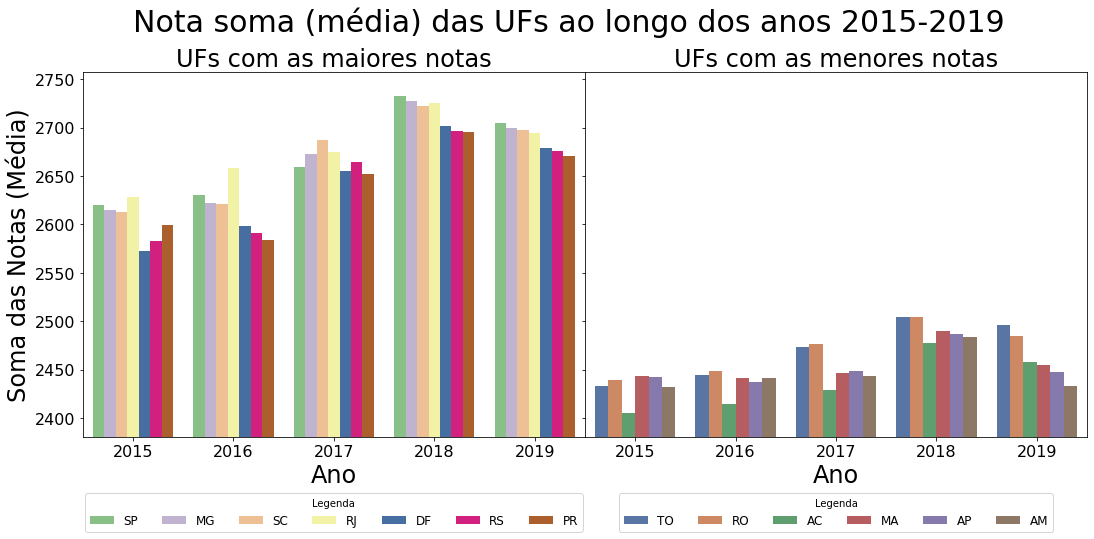

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# PLOT DATA
#--------------------------------------------------------------------------------------------------------------

fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2,figsize=(18,7),sharey=True,gridspec_kw={'hspace': 0, 'wspace': 0})
fig.subplots_adjust(top=0.85)

plt.suptitle(f'Nota soma (média) das UFs ao longo dos anos 2015-2019')
sns.barplot(x='Ano',y='nota_soma',
             hue='SG_UF_RESIDENCIA', 
             data=df_maiores_notas, 
             order=range(2015,2020),
             palette='Accent',
             ax=ax0)
ax0.legend(title='Legenda', bbox_to_anchor=(0.5, -0.275), loc='lower center',prop={'size': 12}, ncol=len(ufs))
ax0.set_title('UFs com as maiores notas')

sns.barplot(x='Ano',y='nota_soma',
             hue='SG_UF_RESIDENCIA', 
             data=df_menores_notas, 
             order=range(2015,2020),
             palette='deep',
             ax=ax1)
ax1.legend(title='Legenda', bbox_to_anchor=(.5, -.275), loc='lower center',prop={'size': 12},ncol=len(ufs2))
#plt.title(f'Nota soma (média) das UFs ao longo dos anos 2015-2019')

plt.ylim([min(vmin,vmin2)-25,max(vmax,vmax2)+25])

ax0.set_ylabel("Soma das Notas (Média)")
ax1.label_outer()
ax1.set_title('UFs com as menores notas')

# DUMP DATAFRAME TO FREE MEMORY
df_maiores_notas=None
df_menores_notas=None
gc.collect()

Mas, espera...  
O que poderia explicar tamanha diferença entre essas regiões?  
Será que se trata de algum **fator... econômico**?

<a name="22"></a>
### Renda Familiar dos Candidatos em Geral

Pra falar em fatores econômicos, podemos consultar uma pergunta do **questionário socioeconômico** registrada nos microdados do ENEM:
> _**Q006: Qual é a renda mensal de sua família?**  
> (Some a sua renda com a dos seus familiares.)_
>
Essa pergunta de múltipla escolha possui uma resposta categórica, com **17 classes diferentes**, de A até Q.  <br>
A correspondência de cada classe está mostrada na Tabela a seguir.

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# QUESTIONÁRIO SÓCIO ECONÔMICO: CATEGORIAS CORRESPONDENTES DA Q006 (RENDA FAMILIAR)
#--------------------------------------------------------------------------------------------------------------
df_categorias_de_renda = pd.DataFrame(zip(sorted(df0['Q006'].dropna().unique()),
    ['Nenhuma renda.',
'Até R$ 998,00.',
'De R$ 998,01 até R$ 1.497,00.',
'De R$ 1.497,01 até R$ 1.996,00.',
'De R$ 1.996,01 até R$ 2.495,00.',
'De R$ 2.495,01 até R$ 2.994,00.',
'De R$ 2.994,01 até R$ 3.992,00.',
'De R$ 3.992,01 até R$ 4.990,00.',
'De R$ 4.990,01 até R$ 5.988,00.',
'De R$ 5.988,01 até R$ 6.986,00.',
'De R$ 6.986,01 até R$ 7.984,00.',
'De R$ 7.984,01 até R$ 8.982,00.',
'De R$ 8.982,01 até R$ 9.980,00.',
'De R$ 9.980,01 até R$ 11.976,00.',
'De R$ 11.976,01 até R$ 14.970,00.',
'De R$ 14.970,01 até R$ 19.960,00.',
'Mais de R$ 19.960,00.']),columns=['Categoria','Renda'])

print(tabulate(df_categorias_de_renda.set_index('Categoria'), headers='keys', tablefmt='psql'))

+-------------+-----------------------------------+
| Categoria   | Renda                             |
|-------------+-----------------------------------|
| A           | Nenhuma renda.                    |
| B           | Até R$ 998,00.                    |
| C           | De R$ 998,01 até R$ 1.497,00.     |
| D           | De R$ 1.497,01 até R$ 1.996,00.   |
| E           | De R$ 1.996,01 até R$ 2.495,00.   |
| F           | De R$ 2.495,01 até R$ 2.994,00.   |
| G           | De R$ 2.994,01 até R$ 3.992,00.   |
| H           | De R$ 3.992,01 até R$ 4.990,00.   |
| I           | De R$ 4.990,01 até R$ 5.988,00.   |
| J           | De R$ 5.988,01 até R$ 6.986,00.   |
| K           | De R$ 6.986,01 até R$ 7.984,00.   |
| L           | De R$ 7.984,01 até R$ 8.982,00.   |
| M           | De R$ 8.982,01 até R$ 9.980,00.   |
| N           | De R$ 9.980,01 até R$ 11.976,00.  |
| O           | De R$ 11.976,01 até R$ 14.970,00. |
| P           | De R$ 14.970,01 até R$ 19.960,00. |
| Q         

Vamos analisar, em geral, como os candidatos do ENEM se distribuem entre essas categorias de renda.  <br>
Vamos comparar entre 2015 e 2019, pra ver se tem alguma diferença. (_spoiler alert_)

<details>    
<summary>
    <font size="3" color="darkred"><b> <i>Spoiler alert<i>:! $\downarrow$</b></font>
</summary>
<p>
<ul>
Podemos notar que não há praticamente nenhuma diferença entre as dribuições dos dois anos.  <br>
A principal mudança é apenas que o número de candidatos selecionado pelos filtros na base de 2019 é menor que na base de 2015.
</ul>
</p>

109

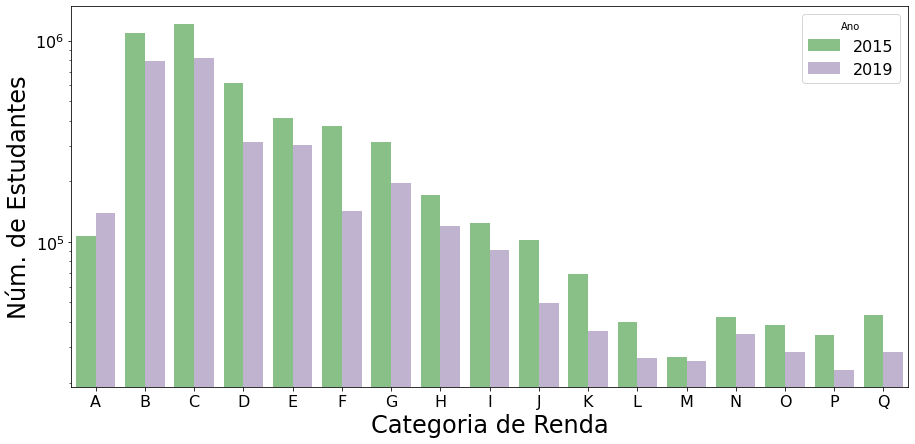

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# QUERY AND PROCESS
#--------------------------------------------------------------------------------------------------------------

df_cnt_renda = df0.query('Ano==2015 or Ano==2019')[['Ano','Q006']].value_counts().reset_index().sort_values(by=['Ano','Q006'])

#--------------------------------------------------------------------------------------------------------------
# PLOT DATA
#--------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(15,7))
sns.barplot(data=df_cnt_renda,x='Q006',y=0,hue='Ano',palette='Accent')

plt.ylabel('Núm. de Estudantes')
plt.xlabel("Categoria de Renda")
plt.yscale('log')

# DUMP DATAFRAME TO FREE MEMORY
df_cnt_renda=None
gc.collect()

<a name="23"></a>
### Relações entre Renda e UF de Residência

Bom, vamos tentar analisar se o fator econômico da renda familiar dos estudantes tem alguma relação com as UFs de origem.  <br>
No gráfico abaixo, vamos separar os estudantes que pertencem aos estados do conjunto {DF, MG, PR, RJ, RS, SC, SP} dos estudantes que pertencem aos estados do conjunto {AC, AM, AP, MA, RO, TO}. <br>
<br> 
Vamos normalizar a quantidade de estudantes em cada categoria de renda pela quantidade total de estudantes em cada grupo de estados, e comparar o percentual relativo de cada categoria entre os grupos. <br>
Não entendeu nada? Relaxa, olha o gráfico primeiro.

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# QUERY AND PROCESS
#--------------------------------------------------------------------------------------------------------------

df_renda_estado_ano = df0[['Q006','SG_UF_RESIDENCIA','Ano']].value_counts().reset_index().rename(columns={'Q006':'Renda','SG_UF_RESIDENCIA':'UF',0:'Num. Estudantes'})
df_renda_estado_ano = df_renda_estado_ano.sort_values(by=['UF','Renda']).query('Ano == 2015 or Ano == 2019')
df_renda_estado_ano['Grupo'] = 0
df_renda_estado_ano['Grupo'][df_renda_estado_ano['UF'].isin(ufs)] = 1

df_renda_estado_ano = df_renda_estado_ano.drop('UF',axis=1)
df_renda_estado_ano = df_renda_estado_ano.groupby(['Ano','Renda','Grupo'])['Num. Estudantes'].sum().reset_index().sort_values(by=['Ano','Grupo','Renda'])

total_estudantes_grp_2015 = df_renda_estado_ano.query('Ano==2015').groupby(['Grupo'])['Num. Estudantes'].sum().reset_index()
for grupo in total_estudantes_grp_2015['Grupo'].to_list():
    query_grp = 'Grupo=='+str(grupo)
    query_grp_ano = query_grp +' and Ano==2015'
    idx_grp = df_renda_estado_ano.query(query_grp_ano).index
    df_renda_estado_ano['Num. Estudantes'].loc[idx_grp] = 100*df_renda_estado_ano['Num. Estudantes'].loc[idx_grp]/total_estudantes_grp_2015.query(query_grp)['Num. Estudantes'].values[0]

total_estudantes_grp_2019 = df_renda_estado_ano.query('Ano==2019').groupby(['Grupo'])['Num. Estudantes'].sum().reset_index()
for grupo in total_estudantes_grp_2019['Grupo'].to_list():
    query_grp = 'Grupo=='+str(grupo)
    query_grp_ano = query_grp +' and Ano==2019'
    idx_grp = df_renda_estado_ano.query(query_grp_ano).index
    df_renda_estado_ano['Num. Estudantes'].loc[idx_grp] = 100*df_renda_estado_ano['Num. Estudantes'].loc[idx_grp]/total_estudantes_grp_2019.query(query_grp)['Num. Estudantes'].values[0]

df_renda_estado_ano['Grupo'] = df_renda_estado_ano['Grupo'].replace({1:'UFs Maiores Notas',0:'UFs Menores Notas'})

C:\Users\3\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\3\.conda\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\3\.conda\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with

O resultado, mostrado no gráfico abaixo, nos leva à seguinte conclusão:
- nas **categorias de renda A até C** (renda familiar até R$\$$ $1.497{,}00$), encontram-se aproximadamente **mais de $60\%$** dos estudantes do grupo de estados  {AC, AM, AP, MA, RO, TO} e **menos de $35\%$** dos estudantes do grupo de estados  {DF, MG, PR, RJ, RS, SC, SP} 
- nas **categorias D em diante** (renda familiar acima de R$\$$ $1.497{,}00$), o percentual relativo de estudantes do grupo de estados {DF, MG, PR, RJ, RS, SC, SP}  é **sempre maior** que o percentual relativo do grupo de estados {AC, AM, AP, MA, RO, TO}.

26892

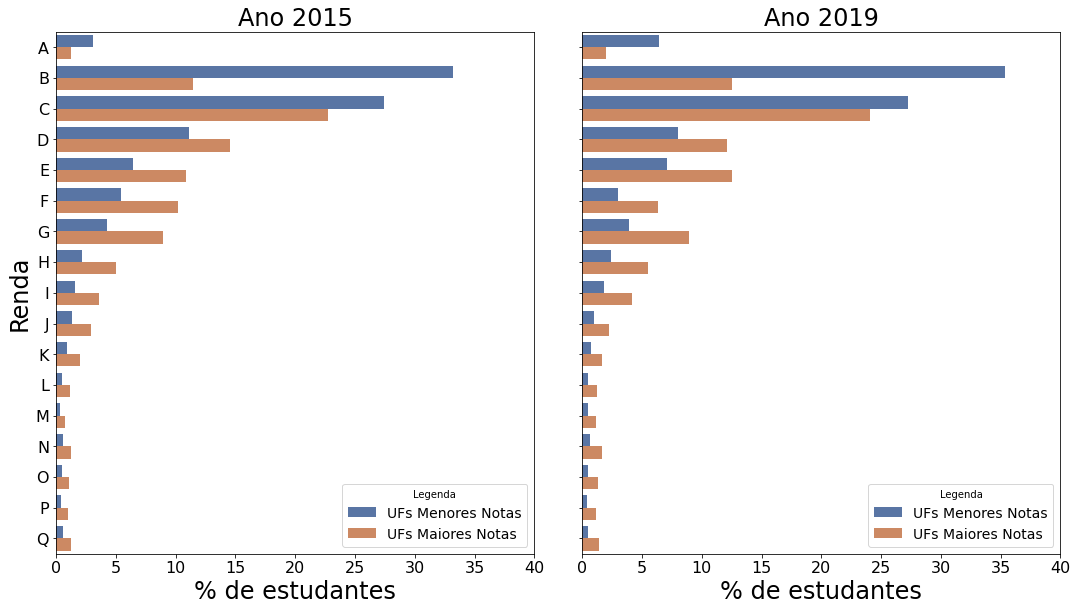

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# PLOT DATA
#--------------------------------------------------------------------------------------------------------------

fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2,figsize=(18,10), sharey=True,gridspec_kw={'hspace': .0, 'wspace': .1}) # 
fig.subplots_adjust(top=0.85)

sns.barplot(x='Num. Estudantes',
                y='Renda',
                hue='Grupo',
                data = df_renda_estado_ano.query('Ano==2015'),
                palette='deep',
                ax=ax0)

ax0.set_xlabel('% de estudantes')
ax0.set_ylabel("Renda")
ax0.set_title('Ano 2015')
ax0.legend(title='Legenda', loc='lower right',prop={'size': 14})
ax0.set_xlim([0,40])

sns.barplot(x='Num. Estudantes',
            y='Renda',
                hue='Grupo',
                data = df_renda_estado_ano.query('Ano==2019'),
                palette='deep',
                ax=ax1)

ax1.set_xlabel('% de estudantes')
ax1.set_ylabel("Renda")
ax1.set_title('Ano 2019')
ax1.legend(title='Legenda', loc='lower right',prop={'size': 14})
ax1.set_xlim([0,40])

ax1.label_outer()

# DUMP DATAFRAME TO FREE MEMORY
df_renda_estado_ano=None
gc.collect()

Opa, talvez isso tenha alguma relação com as médias de notas mais altas e mais baixas da análise anterior... <br>
Talvez, né?

<a name="3"></a>
## 3. Fatores Econômicos Além da Geografia

Ok, a renda familiar parece bastante relevante.  
Se você quiser aprofundar a análise anterior, dá pra combinar as categoria de renda com a pergunta
>Q005	Incluindo você, quantas pessoas moram atualmente em sua residência?
> 
do questionário socieconômico pra medir a renda familiar per capita. _(Desculpa, não deu tempo! Mas faz aí que vai ser legal.)_

Mas onde está o Estado nessa história?  
**Será que as a <font color='red'>educação pública</font> e outras políticas não conseguem compensar essa desigualdade econômica?** <br>
Vamos analisar em que __tipo de escolas__ os estudantes de cada categoria de renda estudam!

<a name="31"></a>
### Escola Pública vs. Escola Particular

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# HELPER FUNCTION
#--------------------------------------------------------------------------------------------------------------
def retorna_perc_renda_por_tipo_de_escola(tipo_escola=2, ano=2019):
    ''' Retorna um DataFrame das escolas do tipo selecionado, no ano selecionado.
        Dados de saída são: renda familiar e percentual relativo de estudantes por categoria de cada renda.
    '''
    query_str = 'TP_ESCOLA==' + str(tipo_escola) +' and Ano==' + str(ano)
    df_tp_escola_renda = df0.query(query_str)['Q006'].value_counts(normalize=True).reset_index()
    df_tp_escola_renda = df_tp_escola_renda.rename(columns={'index':'Renda','Q006':'Perc.'}).sort_values(by=['Renda'])
    df_tp_escola_renda['Perc.'] = 100*df_tp_escola_renda['Perc.']
    df_tp_escola_renda['Tipo']  = dict_tipo_escola[tipo_escola]
    return df_tp_escola_renda.reset_index(drop=True)

No gráfico abaixo, comparamos novamente 2015 e 2019. <br>
Dessa vez, dividimos os estudantes de acordo com a variável "Tipo de Escola", presente nos seus cadastros.  
Os tipos de escola são:
- N/A (não declarado)
- Pública
- Privada 
- Exterior.
Normalizei o total de estudantes de acordo com a categoria do tipo de escola pertencente, para então medir o percentual relativo em cada classe de renda. <br>
Eu sei, parece confuso, mas olha o gráfico, dá pra entender melhor com a representação visual.

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# QUERY AND PROCESS
#--------------------------------------------------------------------------------------------------------------
df_tp_renda_2019 = retorna_perc_renda_por_tipo_de_escola(tipo_escola=1, ano=2019)
for tp_escola in range(2,5):
    df_tp_renda_2019 = pd.concat([df_tp_renda_2019, retorna_perc_renda_por_tipo_de_escola(tipo_escola=tp_escola, ano=2019)])
df_tp_renda_2019.sample(10)

df_tp_renda_2015 = retorna_perc_renda_por_tipo_de_escola(tipo_escola=1, ano=2015)
for tp_escola in range(2,5):
    df_tp_renda_2015 = pd.concat([df_tp_renda_2015, retorna_perc_renda_por_tipo_de_escola(tipo_escola=tp_escola, ano=2015)])
#df_tp_renda_2015.sample(10)

16129

<Figure size 1152x504 with 0 Axes>

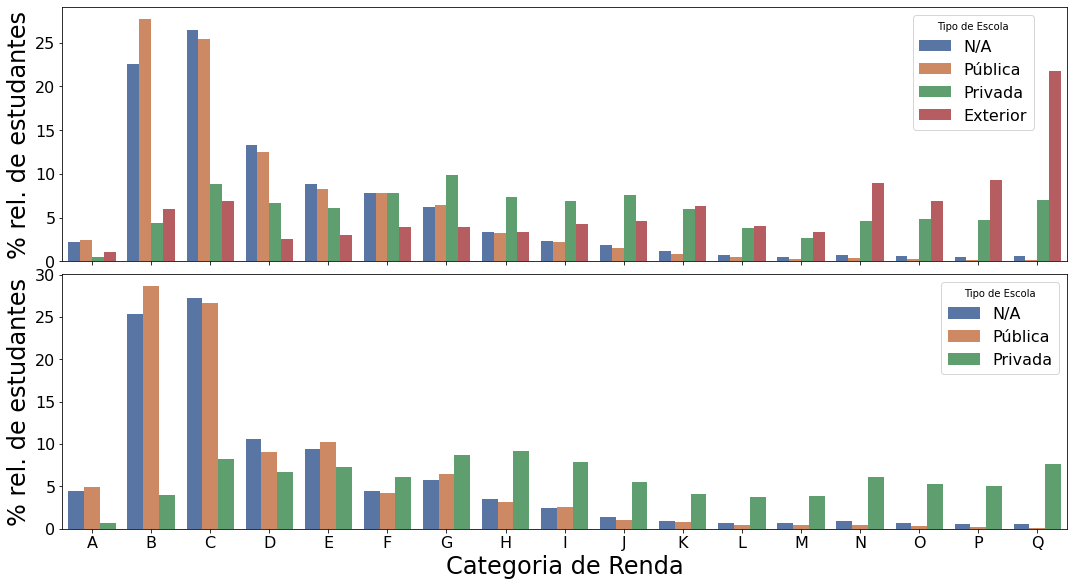

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# PLOT DATA
#--------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(16,7)) # 

fig, (ax0, ax1) = plt.subplots(nrows=2,ncols=1,figsize=(18,10), sharex=True,gridspec_kw={'hspace': .05, 'wspace': 0}) # 
fig.subplots_adjust(top=0.85)

sns.barplot(y='Perc.',
            x='Renda',
            hue='Tipo',
            data = df_tp_renda_2015,
            palette='deep',ax=ax0)

ax0.set_ylabel('% rel. de estudantes')
ax0.set_xlabel("Categoria de Renda")
ax0.legend(title='Tipo de Escola', loc='upper right',bbox_to_anchor=(.975,1),prop={'size': 16})

sns.barplot(y='Perc.',
            x='Renda',
            hue='Tipo',
            data = df_tp_renda_2019,
            palette='deep',ax=ax1)

ax0.label_outer()

ax1.set_ylabel('% rel. de estudantes')
ax1.set_xlabel("Categoria de Renda")
ax1.legend(title='Tipo de Escola', loc='upper right',prop={'size': 16})

# DUMP DATAFRAME TO FREE MEMORY
df_tp_renda_2019 = None
df_tp_renda_2015 = None
gc.collect()

Alguns comentários sobre o gráfico anterior:
- o perfil do N/A é muito parecido com o de escolas públicas, mas sem ter certeza da origem desses estudantes, isso pode causar um ruído na análise;
- em 2019, não temos dados de alunos na categoria "Exterior" (talvez tenham removido a alternativa, ou ninguém foi filtrado pelas nossas condições iniciais!)
- em 2015, nota-se que estudantes da categoria exterior contrariam a distribuição nas categorias de renda (a maior parte está concentrada com rendas familiares acima de R$\$$ $9.980,01$!)
- nos dois anos, a massa de estudantes de escola pública predomina nas categorias de B até E)
- nas escolas privadas, há uma distribuição mais homogênea entre as categorias B e Q, com predominância nas faixas G até I e quase ninguém na faixa A). <br>

É, já esperávamos que fosse caro estudar em escola privada.  <br>
Como isso afeta a nota média dos estudante?  
**Nessa análise, consideraremos apenas o ano de 2019.**

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# QUERY AND PROCESS
#--------------------------------------------------------------------------------------------------------------
ano = '2019'
df_nota_tp_renda = df0.query('Ano=='+ano)[['nota_soma','TP_ESCOLA','Q006']].dropna()
df_nota_tp_renda = df_nota_tp_renda.groupby(["TP_ESCOLA",'Q006']).aggregate(['mean','count']).reset_index()

df_nota_tp_renda[('TP_ESCOLA',      '')] = df_nota_tp_renda[('TP_ESCOLA',      '')].replace(dict_tipo_escola) 
df_nota_tp_renda = pd.DataFrame(df_nota_tp_renda[[('Q006',''),('nota_soma','count'),('TP_ESCOLA',''),('nota_soma','mean')]].values,
                                columns=['Categoria de Renda','Núm. Estudantes', "Tipo de Escola" ,'Nota Soma (Média)'])
#df_nota_tp_renda

No gráfico de bolhas abaixo, podemos ver a ``nota_soma`` (média) dos estudantes por categoria de renda e por tipo de escola.  <br>

Na mesma categoria de renda ("coluna"), quanto mais alta a bolha maior é a média de notas.  <br>
- note que as escolas privadas possuem as maiores notas!
- nas rendas mais baixas, o tipo de escola não declarado tem perfil semelhante ao das escolas públicas (faz sentido)
- nas rendas mais altas, o tipo de escola não declarado tem perfil semelhante ao das escolas particulares (faz sentido também!)

O tamanho das bolhas está sendo utilizado para ilustrar o número total de estudantes que corresponde a essa nota média, em cada categoria.
- nas rendas mais baixas, as bolhas são menores (sim, a maioria das pessoas tem renda familiar baixa)
- enquanto mais para a direita (rendas maiores) as bolhas correspondem a quantidades menores de estudantes.

880

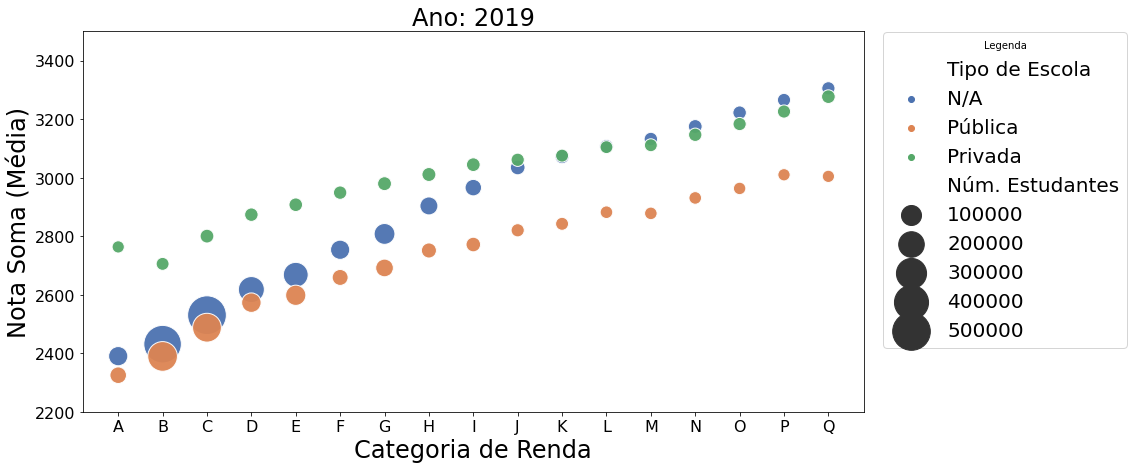

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# PLOT DATA
#--------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(14,7))
sns.scatterplot(x='Categoria de Renda',
                y='Nota Soma (Média)',
                size='Núm. Estudantes',
                hue="Tipo de Escola",
                data = df_nota_tp_renda,
                sizes=(150,1500),
                alpha=0.95,
                palette='deep')
plt.title(f'Ano: {ano}')
plt.ylim([2200,3500])
plt.legend(title='Legenda', bbox_to_anchor=(1.35,1.025), loc='upper right',prop={'size': 20}, ncol=1)

# DUMP DATAFRAME TO FREE MEMORY
df_nota_tp_renda = None
gc.collect()

Podemos interpretar do gráfico anterior que:
> **estudar em escolas privadas e pertencer a um grupo com renda familiar alta inflencia positivamente no aumento das notas médias do ENEM.**

Veja também um gráfico mostrando o comportamento ao longo do tempo:

<img src="https://drive.google.com/uc?export=view&id=1M5b9eNCydo5g7MccRtaN4bnQpGjrCg-m" alt="Animação da evolução das notas médias por tipo de escola (2015 até 2019)." width="1080px"/> 


<a name="32"></a>
### Só o tempo cura

Um fato razoável de ser considerado é que, seguindo um curso regular, sem imprevistos, a maior parte dos candidatos do ENEM deve estar cursando, finalizando o ser recém egressos do ensino médio.  
Isso implica que são, em maioria, jovens e adolescentes.  <br>
Nós **já removemos todos os candidatos que marcaram estar fazendo o ENEM como treineiros**, então podemos assumir com tranquilidade que todos os candidatos do dataset estão interessados em pontuar uma nota alta para ingressar em cursos de graduação nas Universidades.  <br>

Portanto, vem a pergunta: **será que a idade do candidato influencia no seu desempenho?**  
Vamos investigar.  
Vamos fazer uma linha do tempo das idades dos candidatos e avaliar a distribuição das suas ```nota_soma```.  <br>
Vamos separar também entre escolas públicas e escolas particulares (descartando os que não declararam).  
**Nessa análise, consideramos apenas o ano de 2019.**

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# QUERY AND PROCESS
#--------------------------------------------------------------------------------------------------------------
ano='2019'
query_ano = 'Ano=='+ano
query_idade = 'NU_IDADE>=13'
all_queries = query_ano + ' and ' + query_idade

cols_to_use = ['nota_soma','NU_IDADE','TP_ESCOLA']
df_nota_idade = df0.query(all_queries)[cols_to_use]

df_nota_idade = df_nota_idade[df_nota_idade['TP_ESCOLA']!=1]
df_nota_idade['TP_ESCOLA'] = df_nota_idade['TP_ESCOLA'].replace(dict_tipo_escola)

idades = df_nota_idade['NU_IDADE'].unique().astype('int32').tolist()

No gráfico abaixo, percebemos as seguintes tendências:
- a nota média dos estudantes é **mais alta na faixa etária entre 15 e 19 anos**
- nessa faixa, **alunos de escolas privadas tem uma distruição de notas mais alta** que alunos de escola pública
- **a partir dos $21$ anos, parece haver menor relevância da influência do tipo de escola de origem na nota média**.  

Ou seja, podemos imaginar que, com o tempo, os estudantes devem esquecer alguns conteúdos que estudaram no ensino médio.  
Além disso, por serem mais velhos e talvez estarem empregados e trabalhando, provavelmente investem nos mesmos tipos de cursos preparatórios para fazer a prova.

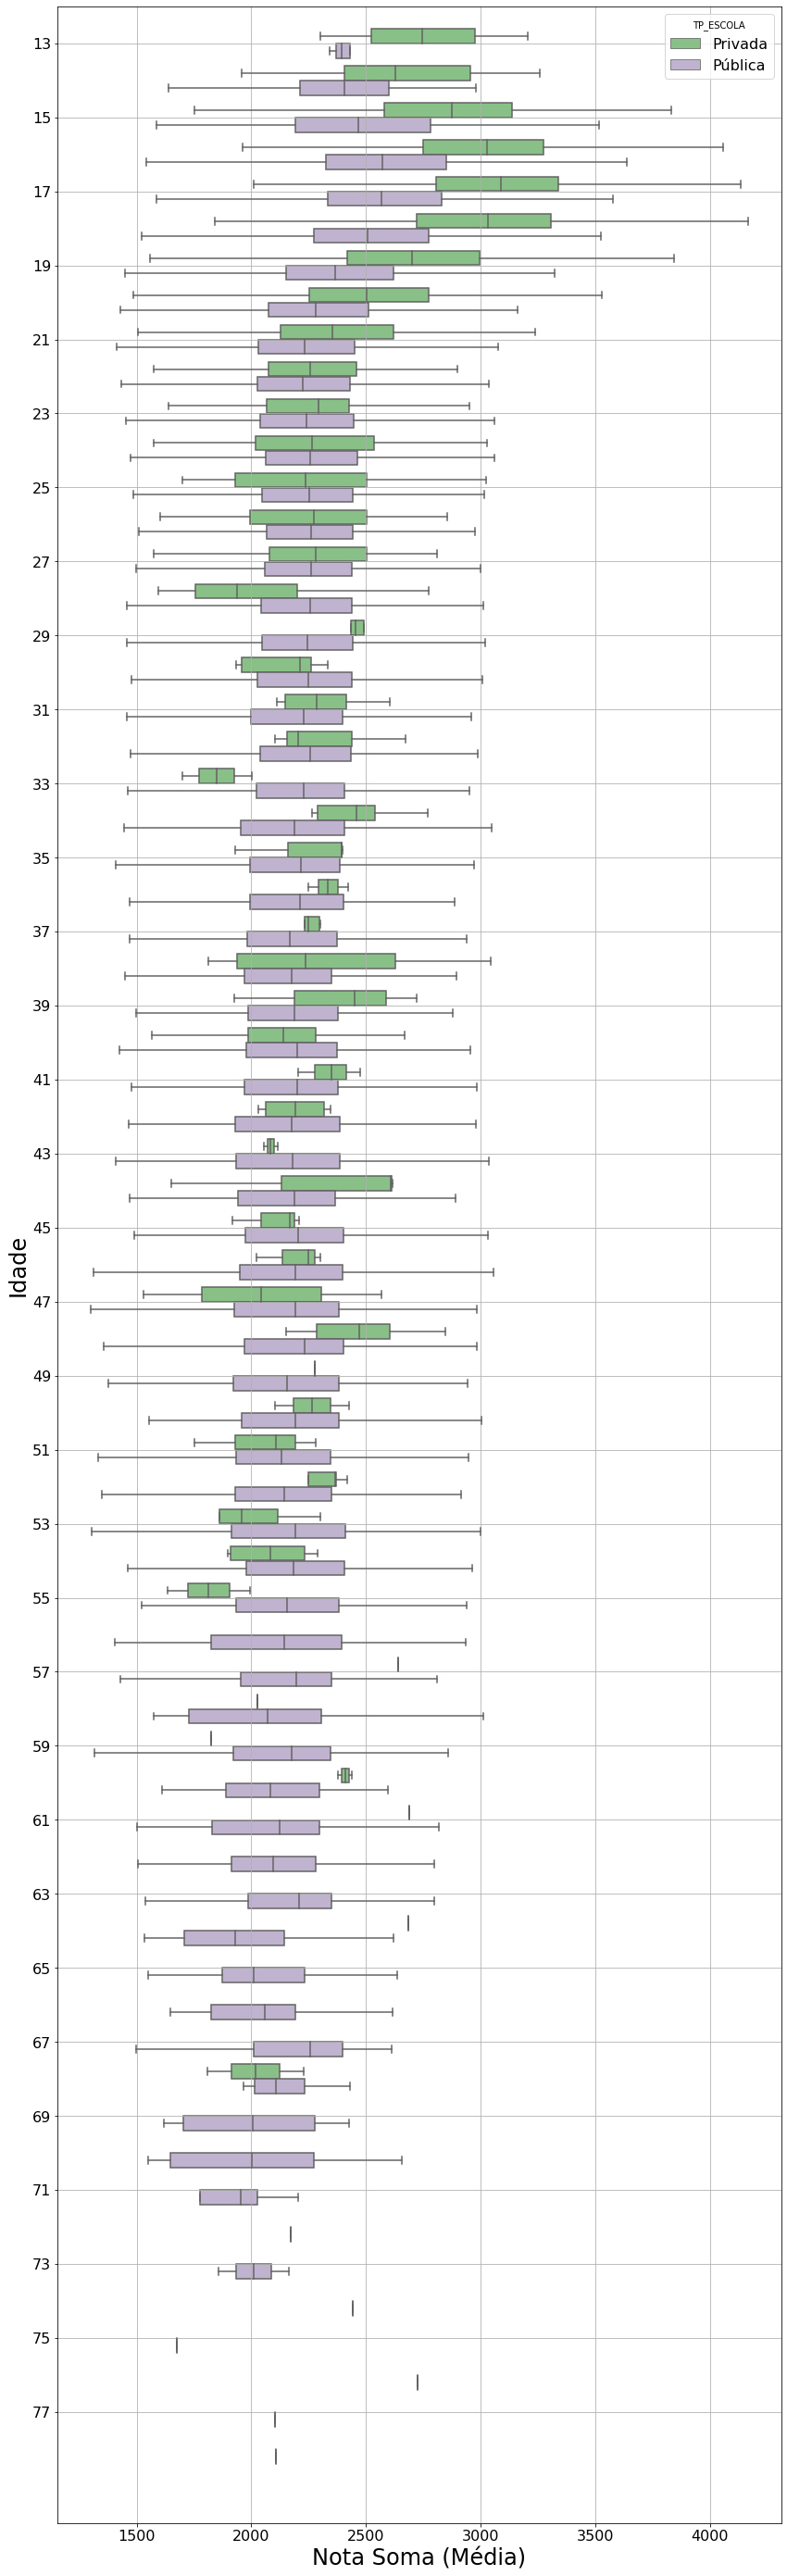

4200

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# PLOT DATA
#--------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(14,50))

sns.boxplot(data=df_nota_idade,
           y='NU_IDADE',
           x='nota_soma',
           hue='TP_ESCOLA',
           showfliers = False,
           palette='Accent',
           orient='h')

ticks = range(min(idades),max(idades))
plt.ylabel('Idade')
plt.xlabel('Nota Soma (Média)')
plt.yticks(ticks=range(len(idades))[::2],labels=ticks[::2])
plt.ylim([-1,len(idades)+1])
ax.invert_yaxis()
ax.grid()
plt.show()

# DUMP DATAFRAME TO FREE MEMORY
df_nota_idade = None
gc.collect()

<a name="33"></a>
### Público e de Qualidade!

Existe um campo dos Microdados do ENEM que separa as **escolas** dos candidatos de acordo com a sua **natureza administrativa**:
- Escolas Municipais
- Escolas Estaduais
- Escolas Federais
- Escolas Privadas.

Entretanto, infelizmente, a maior parte dos candidatos não possui nenhum valor nesse campo. <br>
Por exemplo, **em 2019, apenas $4.673\%$ dos candidatos** que filtramos tem esse campo preenchido. <br>
Vamos usar essa amostra e avaliar se há alguma diferença entre as escolas públicas municipais, estaduais e federais.

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# QUERY AND PROCESS
#--------------------------------------------------------------------------------------------------------------
ano='2019'
query_ano = 'Ano=='+ano
query_idade = 'NU_IDADE>=13 and NU_IDADE<=65'
all_queries = query_ano + ' and ' + query_idade

cols_to_use = ['nota_soma','TP_DEPENDENCIA_ADM_ESC', 'NU_IDADE']
df_nota_idade = df0.query(all_queries)[cols_to_use].dropna()
print(len(df_nota_idade),100*len(df_nota_idade)/len(df0))

df_nota_idade['TP_DEPENDENCIA_ADM_ESC'] = df_nota_idade['TP_DEPENDENCIA_ADM_ESC'].replace(dict_adm_escola)

idades = df_nota_idade['NU_IDADE'].unique().astype('int32').tolist()

952762 4.673607964208389


Esse é um dos resultados que eu mais gosto de observar.  <br>
Olhando para a faixa etária onde vimos um desnível entre as notas das escolas públicas e privadas no gráfico anterior, agora temos uma nova informação.  <br>
Nessa mesma região, **as escolas federais mostram um desempenho muito próximo do desempenho das escolas privadas**! <br>
Isso é um reflexo da qualidade de ensino dos Institutos Federais (antigas escolas técnicas, CEFETs, etc).   <br>
Não só isso, como **na faixa dos $19$ aos $24$ anos ainda superam o desempenho das escolas particulares**. <br> (em alguns IFs, os cursos técnicos fazem com que a duração total do ensino médio seja de 4 anos, logo muitos alunos dessas escolas fazem o ENEM a partir dos 18 ou 19 anos) <br>
Obs.: Não encontrei se as escolas militares estão dentro dessa categoria "Federal", mas suspeito que sim, pois geralmente apresentam bom desempenho também.

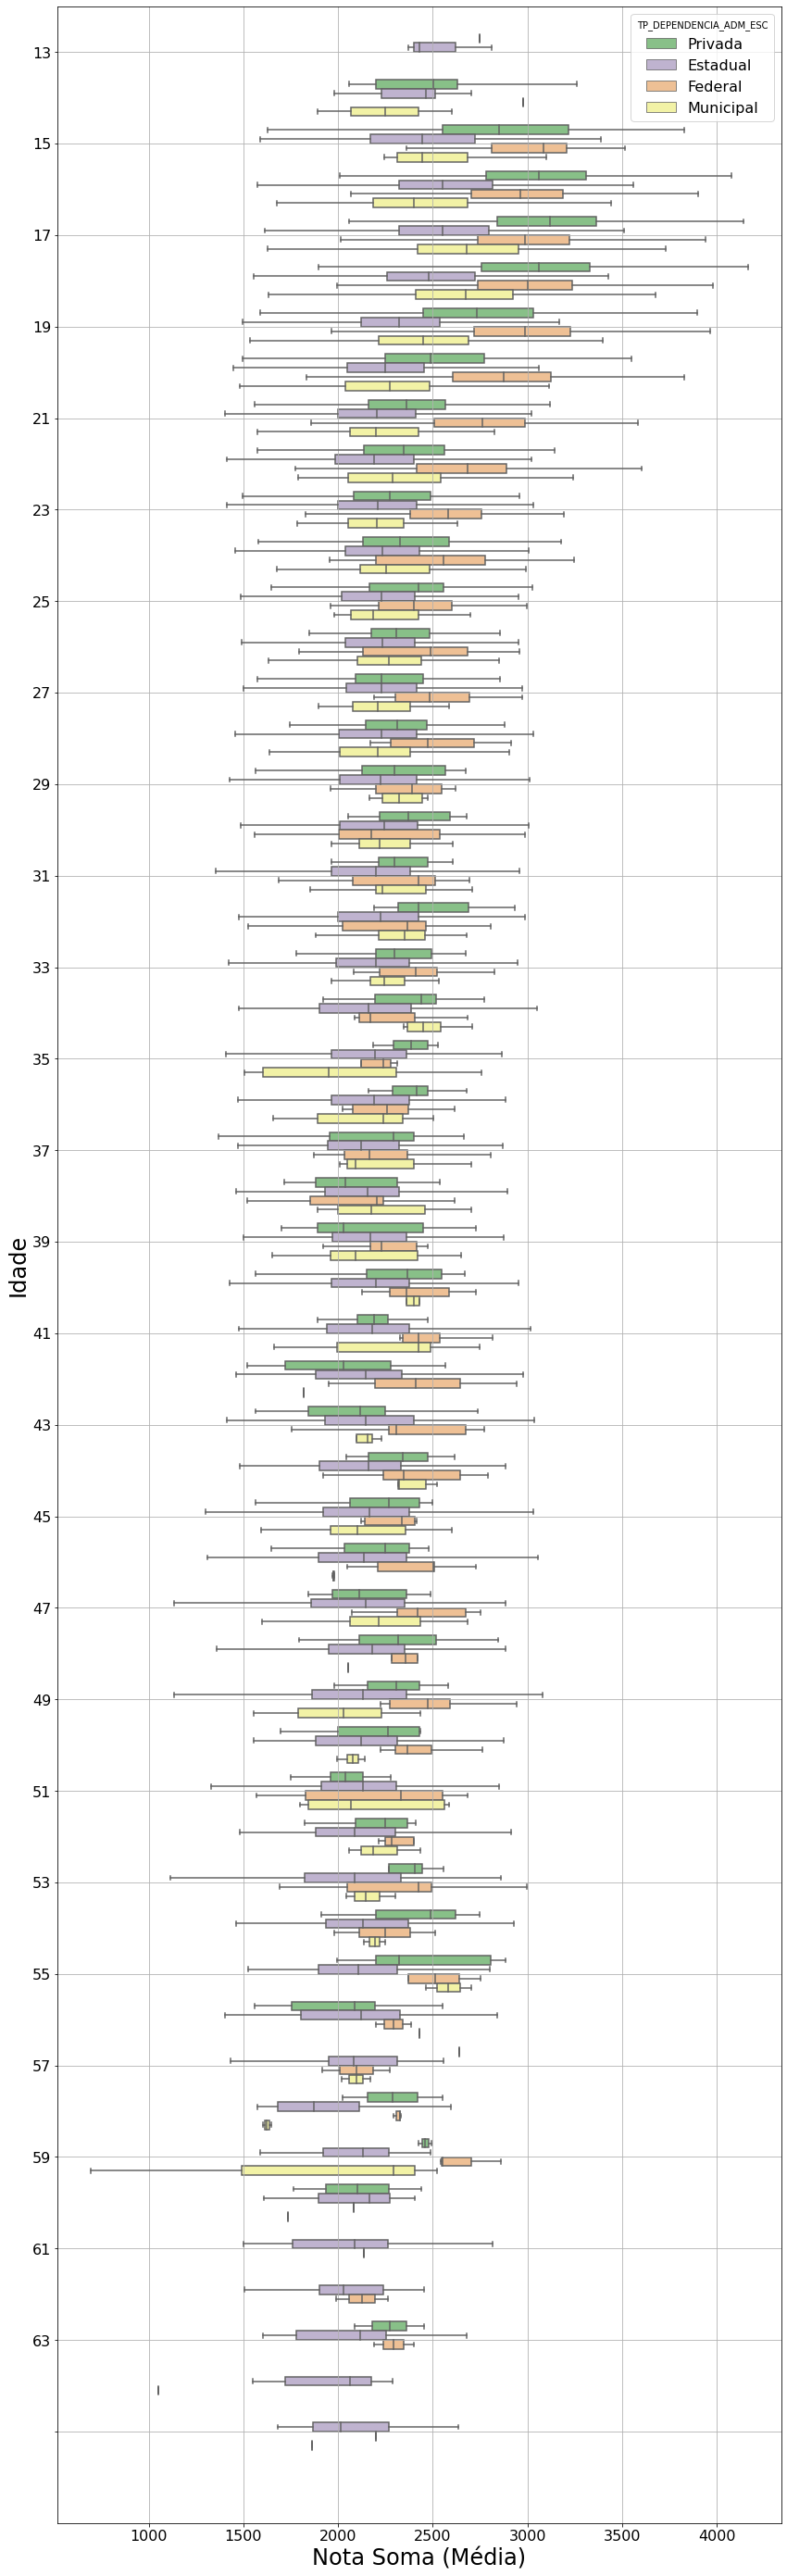

27

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# PLOT DATA
#--------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(14,50))

sns.boxplot(data=df_nota_idade,
           y='NU_IDADE',
           x='nota_soma',
           hue='TP_DEPENDENCIA_ADM_ESC',
           showfliers = False,
           palette='Accent',
           orient='h')

ticks = range(min(idades),max(idades))
plt.ylabel('Idade')
plt.xlabel('Nota Soma (Média)')
plt.yticks(ticks=range(len(idades))[::2],labels=ticks[::2])
plt.ylim([-1,len(idades)+1])

ax.invert_yaxis()
ax.grid()
plt.show()

# DUMP DATAFRAME TO FREE MEMORY
df_nota_idade = None
gc.collect()

Para concluir essa parte, ressalto que infelizmente o acesso às escolas federais é limitado, e também existe um 'vestibular' (concurso público) para selecionar os alunos nesse ingresso. Em muitos Institutos Federais, adota-se um esquema de cotas (para escolas públicas, de cor/raça, de inclusão, etc) para que esse concurso não se torne mais um fator que acentua as desigualdades das escolas de ensino fundamental (municipal vs. privado).  <br>

Embora haja um investimento alto para atingir o grau de qualidade das escolas federais, e difícil de ser ampliado em larga escala, é um modelo público de excelência que mostra que é possível sim ter alta qualidade no ensino público brasileiro para os anos de ensino médio.

<a name="4"></a>
## 4. Existe Racismo Estrutural? (_spoiler alert_: sim)

Ok, já fizemos uma exposição de alguns fatores econômicos (renda familiar, economia regional e escolas públicas vs. privadas) que influenciam nas notas do ENEM.  
Agora, será que as características individuais dos candidatos podem revelar alguma coisa sobre as suas notas médias?  
Será que a cor/raça dos estudantes revela alguma coisa sobre as suas oportunidades e o seu desempenho?

<a name="41"></a>
### Divergências Regionais

Antes de você saltar em conclusões precipitadas, vamos esclarecer algumas coisas.  
Nos microdados, os candidatos **declaram um campo de "Cor/Raça"**, uma variável categórica com **6 classes** diferentes:
- Não declarado
- Branca
- Preta
- Parda
- Amarela
- Indígena 
- Não dispõe da informação  

sendo que essa última classe não está mais presente nos microdados apenas a partir do ano de 2017.  
Para fins de análise, vou usar a categoria ```N/A``` tanto para "_Não declarado_" quanto para "_Não dispõe da informação_".

Outra questão relevante é sobre as classes **"_Amarela_"** e **"_Parda_"**.  <br>
De acordo com as [definições do IBGE](https://biblioteca.ibge.gov.br/visualizacao/livros/liv63405.pdf), e colocando à parte toda discussão sociológica e filosófica desses termos, a categoria "amarela" foi incluida pela primeira vez em 1940 para considerar as imigrações japonesas que haviam ocorrido no país. Uma [reportagem da VEJA, em 2013,](https://veja.abril.com.br/brasil/censo-2010-erra-ao-indicar-aumento-de-asiaticos-no-pais/) comenta que em estados do Nordeste do país, muitas pessoas da população se identificaram como "amarelas", mesmo sem nenhuma descendência asiática, provavelmente por não compreender o propósito e significado desse termo.  <br>

Já o uso do termo _pardo(a)_ possui uma história mais complicada ainda. Retirando um trecho da mesma refência anterior:
> _"Em relação à categoria parda, constata-se variação nos percentuais de utilização
da mesma entre as Unidades da Federação pesquisadas, alcançando cerca de 4%
no Rio Grande do Sul e menos de 30% no Distrito Federal. Sem dúvida alguma, as
distribuições percentuais das três categorias analisadas até aqui refletem variações
próprias da composição étnico-racial das Unidades da Federação investigadas,
revelando, entretanto, também algumas preferências em relação ao uso destes termos."_
>

Dito isso, observando os dados, precebemos algumas curiosidades:
- sobre a cor "Amarela", as estatísticas dos estados do PR e SP parecem corresponder realmente à descendências asiáticas, pois com o aumento da renda desses grupos, suas notas ultrapassam ou equiparam às notas médias da categoria "Branca"
- as estatísticas da cor "Parda" costumam oscilar entre os dados das categorias "Preta" (sempre inferiores) e "Branca", o que provavelmente revela que ainda existe bastante confusão sobre o uso desse termo, ainda variável de acordo com a região do país.

Vamos analisar, por exemplo, a evolução das notas desses grupos entre 2015 e 2019, filtrando os dados por UF, e comprovar essas variações. 

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# QUERY AND PROCESS
#--------------------------------------------------------------------------------------------------------------

uf0 = '"SP"'
query_uf = 'SG_UF_RESIDENCIA=='+uf0
df_uf_SP = df0.query(query_uf).drop('SG_UF_RESIDENCIA',axis=1)
df_uf_cor_ano_SP = df_uf_SP.groupby(['TP_COR_RACA','Ano'])["nota_soma"].aggregate(['mean','count']).reset_index()
df_uf_cor_ano_SP['TP_COR_RACA'] = df_uf_cor_ano_SP['TP_COR_RACA'].replace(dict_cor_raca)

uf1 = '"BA"'
query_uf = 'SG_UF_RESIDENCIA=='+uf1
df_uf_BA = df0.query(query_uf).drop('SG_UF_RESIDENCIA',axis=1)
df_uf_cor_ano_BA = df_uf_BA.groupby(['TP_COR_RACA','Ano'])["nota_soma"].aggregate(['mean','count']).reset_index()
df_uf_cor_ano_BA['TP_COR_RACA'] = df_uf_cor_ano_BA['TP_COR_RACA'].replace(dict_cor_raca)

646

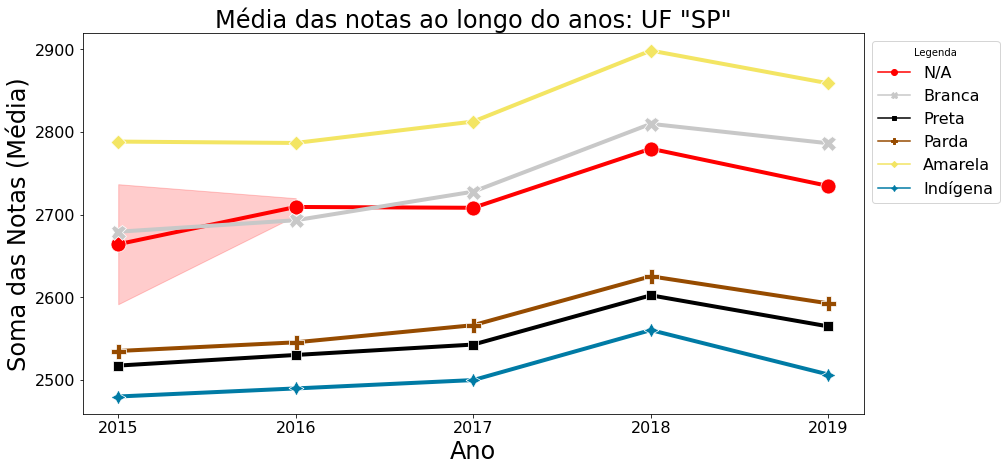

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# PLOT_DATA
#--------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(14,7))
sns.lineplot(x='Ano',y='mean',
             hue='TP_COR_RACA', 
             style='TP_COR_RACA',
             linewidth=4,
             markersize=15,
             data=df_uf_cor_ano_SP,
             markers=True, dashes=False, 
             palette=customPalette)
plt.legend(title='Legenda', bbox_to_anchor=(1, 1), loc='upper left',prop={'size': 16})
plt.xticks(ticks=range(2015,2020))
plt.title(f'Média das notas ao longo do anos: UF {uf0}')
plt.ylabel("Soma das Notas (Média)")

# DUMP DATAFRAME TO FREE MEMORY
df_uf_SP=None
df_uf_cor_ano_SP= None
gc.collect()

5063

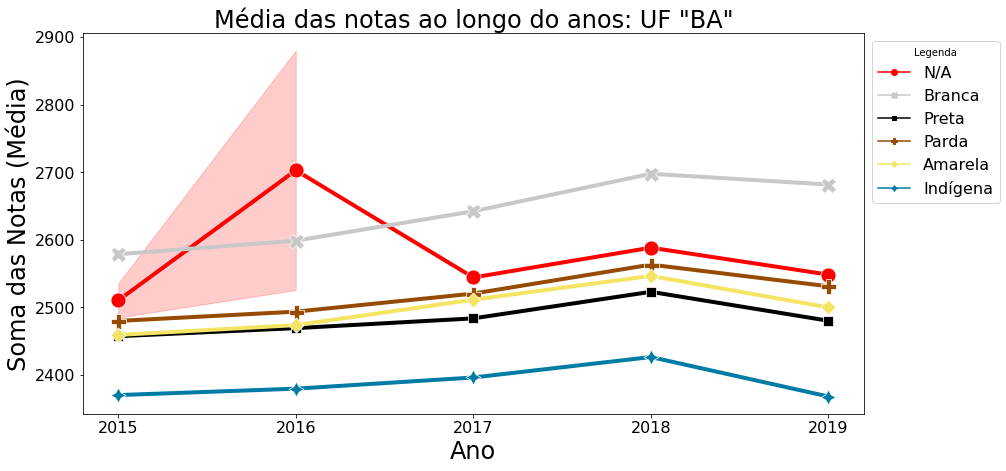

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# PLOT_DATA
#--------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(14,7))
sns.lineplot(x='Ano',y='mean',
             hue='TP_COR_RACA', 
             style='TP_COR_RACA',
             linewidth=4,
             markersize=15,
             data=df_uf_cor_ano_BA,
             markers=True, dashes=False, 
             palette=customPalette)
plt.legend(title='Legenda', bbox_to_anchor=(1, 1), loc='upper left',prop={'size': 16})
plt.xticks(ticks=range(2015,2020))
plt.title(f'Média das notas ao longo do anos: UF {uf1}')
plt.ylabel("Soma das Notas (Média)")

# DUMP DATAFRAME TO FREE MEMORY
df_uf_BA=None
df_uf_cor_ano_BA= None
gc.collect()

De qualquer maneira, independente do estado, algumas coisas ficam claras:
- a nota média da população "Índigena" e "Preta" está bastante abaixo da nota média da população "Branca".

<a name="42"></a>
### O problema é econômico!!??

Vamos analisar o efeito da renda e cruzar com as declarações de cor/raça.  
**Nessa análise, consideraremos apenas o ano de 2019.**

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# QUERY AND PROCESS
#--------------------------------------------------------------------------------------------------------------
df_nota_tp_cor = df0.query('Ano==2019')[['nota_soma','TP_COR_RACA','Q006']].dropna()
df_nota_tp_cor = df_nota_tp_cor.groupby(["TP_COR_RACA",'Q006']).aggregate(['mean','count']).reset_index()

df_nota_tp_cor = pd.DataFrame(df_nota_tp_cor[[('Q006',''),('nota_soma','count'),('TP_COR_RACA',''),('nota_soma','mean')]].values,
            columns=['Categoria de Renda','Núm. Estudantes', "Cor/Raça" ,'Nota Soma (Média)'])

df_nota_tp_cor['Cor/Raça'] = df_nota_tp_cor['Cor/Raça'].replace(dict_cor_raca)

Tem algo no gráfico abaixo que é bastante incômodo:
- **mesmo com o aumento de categoria de renda, as notas médias dos candidatos das populações "Índigena", "Preta" e "Parda" não equaliza com "Amarela"/"Branca"**!

Outro ponto curioso é a transição da nota média da população "Amarela" ao longo das categorias de renda.  
Podemos supor que a identificação nas categorias de renda mais baixa não corresponde à população asiática, mas sim a uma confusão com o termo.  
Porém, não temos como validar essa hipótese com esses dados.  

Além disso, temos a categoria de cor/raça não-declarada seguindo o perfil da população "Branca" para rendas mais altas (acima de "C").  
Para as rendas de A até C, os não-declarados seguem o perfil da população "Parda".


Por fim, note o tamanho das bolhas (quantidade de pessoas).  
Parece que as bolhas "Parda" e "Preta" são bem maiores nas categorias de baixa renda.

5465

<Figure size 1152x504 with 0 Axes>

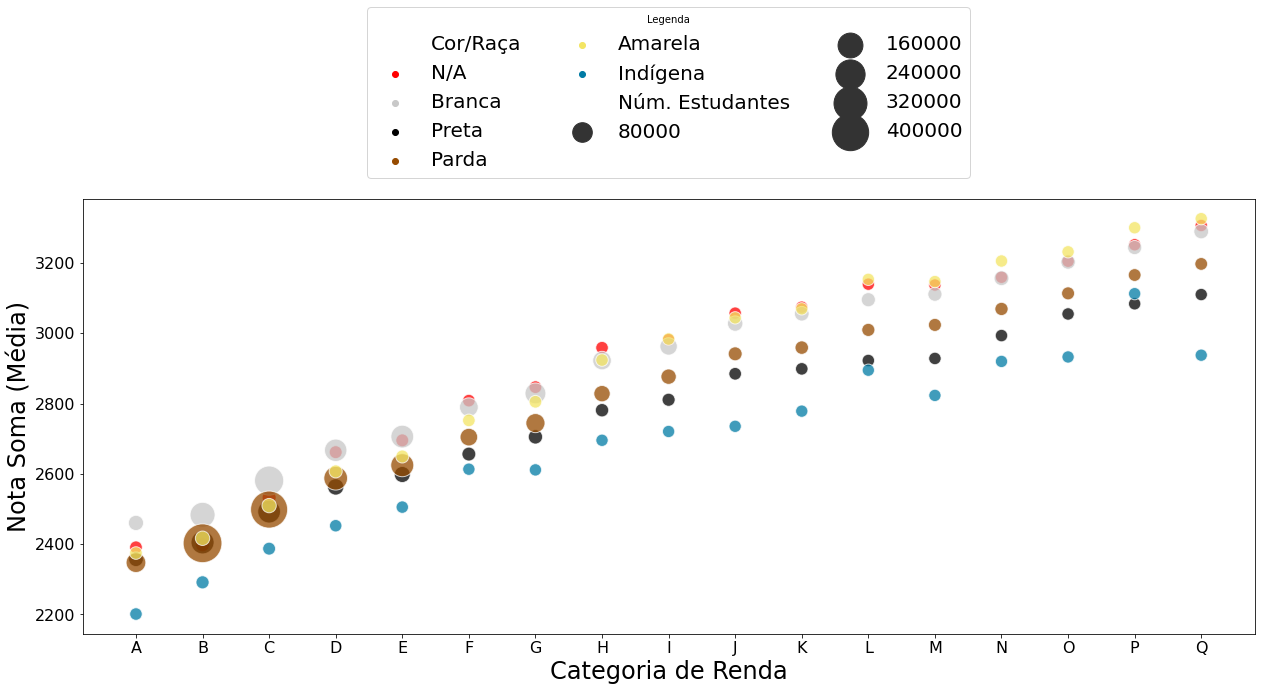

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# PLOT DATA
#--------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(16,7))

plt.figure(figsize=(21,8))
sns.scatterplot(x='Categoria de Renda',
                y='Nota Soma (Média)',
                size='Núm. Estudantes',
                hue="Cor/Raça",
                data = df_nota_tp_cor,
                sizes=(150,1500),
                alpha=0.75,
                palette=customPalette)
plt.legend(title='Legenda', bbox_to_anchor=(.5,1.025), loc='lower center',prop={'size': 20}, ncol=3)

# DUMP DATAFRAME TO FREE MEMORY
df_nota_tp_cor = None
gc.collect()

Vamos analisar com mais profunidade, visualizando as distribuições de nota em vez de apenas a nota média.  
Vamos fazer uma sequência de boxplots, para cada categoria de renda, e comparar também as diferentes categorias de cor/raça.

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# QUERY AND PROCESS
#--------------------------------------------------------------------------------------------------------------
ano='2015'

df_nota_cor_renda = df0.query('Ano=='+ano)[['nota_soma','TP_COR_RACA','Q006']].dropna()
df_nota_cor_renda = df_nota_cor_renda.sort_values(by=['TP_COR_RACA','Q006'])
df_nota_cor_renda['TP_COR_RACA'] = df_nota_cor_renda['TP_COR_RACA'].replace(dict_cor_raca)

df_nota_cor_renda = df_nota_cor_renda.rename(columns={'nota_soma':'Nota Soma (Média)','TP_COR_RACA':"Cor/Raça",'Q006':"Categoria de Renda"})

Um fator que diminui o incômodo da análise anterior é que a dispersão de notas é muito grande para todas as populações.  <br>
Existem intersecções de notas entre todas as categorias, para uma mesma classe de renda.  <br>
Mesmo assim, a mediana parece ainda favorecer mais as populações "Branca", "Amarela" e "N/A".

5107

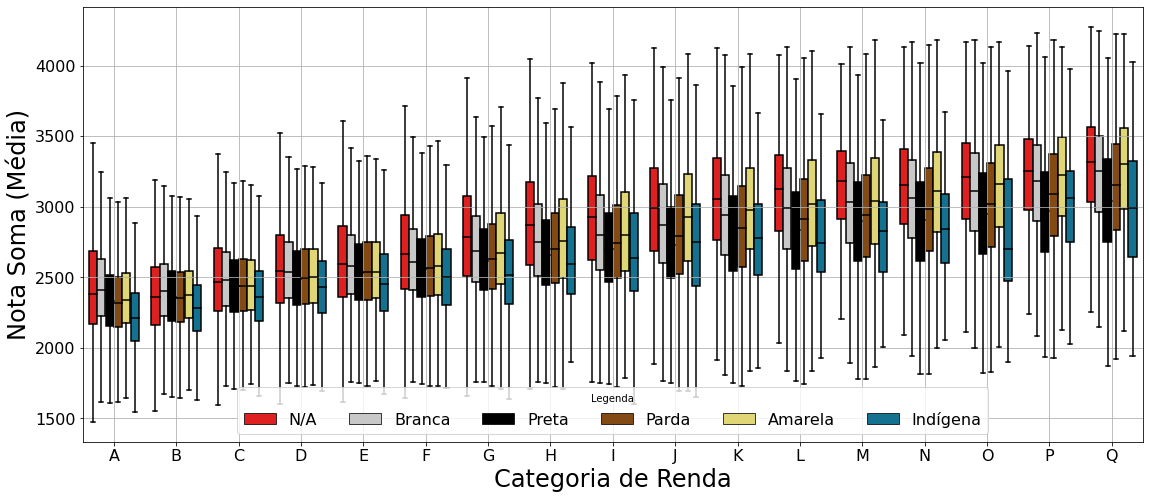

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# PLOT DATA
#--------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(19,8))

sns.boxplot(x='Categoria de Renda',
                y='Nota Soma (Média)',
                hue="Cor/Raça",
                data = df_nota_cor_renda,
                palette=customPalette,
               order=lista_A_to_Q,
            showfliers = False)
plt.xlabel('Categoria de Renda')
plt.ylabel("Nota Soma (Média)")
plt.legend(title='Legenda', loc='lower center',prop={'size': 16},ncol=len(colors))
plt.grid()

# DUMP DATAFRAME TO FREE MEMORY
df_nota_cor_renda = None
gc.collect()

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# HELPER FUNCTION
#--------------------------------------------------------------------------------------------------------------
def return_df_nota_cor_tp_normalizado(tipo_escola=1):
    ''' Retorna um DataFrame do tipo da escola selecionada.
        Contém dados da categoria cor/raça (quantidade de estudantes e média da nota_soma por categoria).
    '''
    query_str = 'TP_ESCOLA=='+str(tipo_escola)
    df_tp = df_nota_cor_tp.query(query_str).groupby(['TP_COR_RACA','TP_ESCOLA']).aggregate(['mean','count']).reset_index()
    df_tp[('nota_soma','count')] = 100*df_tp[('nota_soma','count')]/df_tp[('nota_soma','count')].sum()
    df_tp = pd.DataFrame(df_tp[[('TP_ESCOLA',''),('TP_COR_RACA',''),('nota_soma','count'),('nota_soma','mean')]].values,
                                  columns=['Tipo de Escola',"Cor/Raça" ,'Perc. %', 'Nota Soma (Média)'])
    return df_tp

Vamos fazer mais uma análise, considerando agora o tipo de escola de origem para cada população dessas classes de cor/raça.  
Vamos normalizar o trazer o percentual de estudantes por cor/raça em cada tipo de escola.  
Ou seja, a soma dos percentuais da escola privada deve ir até 100%, assim como na escola pública. Veja o gráfico logo a seguir.

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# QUERY AND PROCESS
#--------------------------------------------------------------------------------------------------------------
ano = '2019'
df_nota_cor_tp = df0.query('Ano=='+ano)[['nota_soma','TP_COR_RACA','TP_ESCOLA']].dropna()

df_tp = return_df_nota_cor_tp_normalizado(tipo_escola=1)
for tp in range(2,5):
    df_tp = pd.concat([df_tp,  return_df_nota_cor_tp_normalizado(tipo_escola=tp)])
df_tp = df_tp.reset_index(drop=True)

df_tp['Cor/Raça']       = df_tp['Cor/Raça'].replace(dict_cor_raca)
df_tp['Tipo de Escola'] = df_tp['Tipo de Escola'].replace(dict_tipo_escola)

Vamos pontuar algumas coisas interessantes do gráfico abaixo:
- **a nota média do grupo de escolas privadas pode ser claramente separada (é mais alta) das notas dos outros tipos de escola**, para todas as classes de cor/raça 
- mesmo assim, **ainda há uma diferença significativa entre cada categoria de cor/raça, mesmo na escola privada**...
- observe o tamanho das bolhas, enquanto a maior parte da população parda e preta está na escola pública, a maioria da população branca se concentra na escola privada<br>
(nesse momento, o ruído dos "N/A" torna difícil confirmar essa observação com muita certeza).

48023

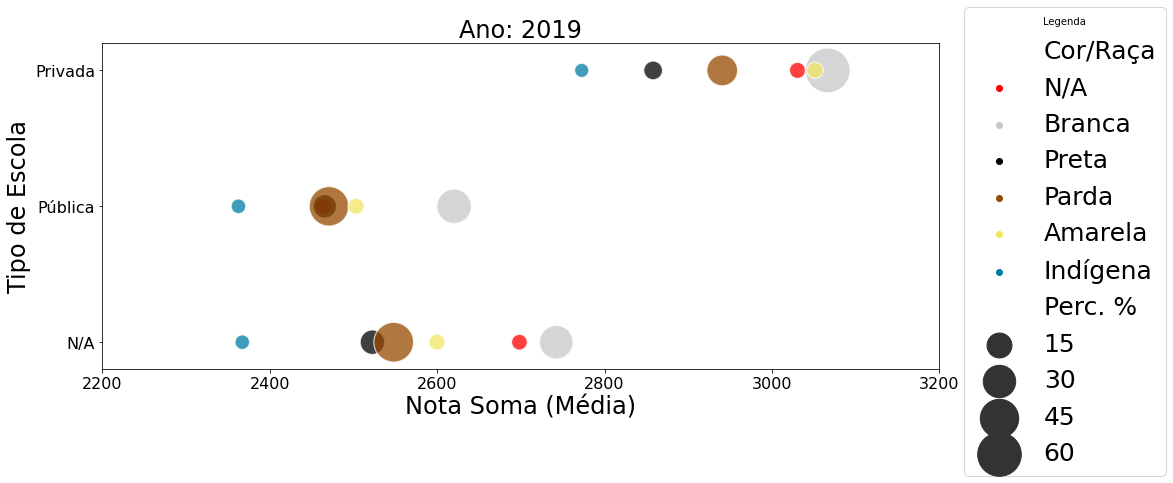

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# PLOT DATA
#--------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(15,6))

sns.scatterplot(y='Tipo de Escola',
                x='Nota Soma (Média)',
                size='Perc. %',
                hue="Cor/Raça",
                data = df_tp,
                sizes=(200,2000),
                alpha=0.75,
                palette=customPalette)
plt.ylabel('Tipo de Escola')
plt.xlabel("Nota Soma (Média)")
plt.ylim(-.2,2.2)
plt.xlim([2200,3200])
plt.title(f'Ano: {ano}')
plt.legend(title='Legenda', bbox_to_anchor=(1.15,1.15), loc='upper center',prop={'size': 25}, ncol=1)

# DUMP DATAFRAME TO FREE MEMORY
df_nota_cor_tp = None
df_tp          = None
gc.collect()

Veja também uma animação da evolução desses dados ao longo dos anos de 2015 a 2019:

<img src="https://drive.google.com/uc?export=view&id=1iREmIM1_KVa4N8U8ESPVnM46ISq7XoA2" alt="Animação da evolução das notas médias por tipo de cor/raça (2015 até 2019)." width="1080px"/> 

<a name="5"></a>
## 5. Questões de Gênero e o Papel Social das Mulheres no Brasil

É difícil explicar as causas do fenômeno acima.  
Discutir racismo estrutural é complexo, e os dados que temos disponíveis podem ser bastante limitados.  
Lembre ainda que, ao falar de racismo, têm-se que lembrar da escravidão e do massacre dos povos negros e indígenas, e das consequências temporais disso.

<a name="51"></a>
### Influências do passado: grau de escolaridade da Mãe

Vamos fazer uma **ligação entre cor/raça e gênero**, analisando a seguinte pergunta do questionário socioeconômico:
> **_Q002: Até que série sua mãe, ou a mulher responsável por você, estudou?_**
>
Essa resposta é de múltipla escolha, e a Tabela abaixo resume as possíveis respostas ($8$ classes).

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# QUESTIONÁRIO SÓCIO ECONÔMICO: CATEGORIAS CORRESPONDENTES DA Q002 (ESCOLARIDADE DA MÃE)
#--------------------------------------------------------------------------------------------------------------

df_escolaridade_mae = pd.DataFrame(zip(sorted(df0['Q002'].dropna().unique()),
['Nunca estudou.',
'Não completou a 4ª série/5º ano do Ensino Fundamental.',
'Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.',
'Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.',
'Completou o Ensino Médio, mas não completou a Faculdade.',
'Completou a Faculdade, mas não completou a Pós-graduação.',
'Completou a Pós-graduação.',
'Não sei.'
]),columns=['Categoria','Escolaridade da Mae'])

print(tabulate(df_escolaridade_mae.set_index('Categoria'), headers='keys', tablefmt='psql'))

+-------------+-----------------------------------------------------------------------------------------+
| Categoria   | Escolaridade da Mae                                                                     |
|-------------+-----------------------------------------------------------------------------------------|
| A           | Nunca estudou.                                                                          |
| B           | Não completou a 4ª série/5º ano do Ensino Fundamental.                                  |
| C           | Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental. |
| D           | Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.    |
| E           | Completou o Ensino Médio, mas não completou a Faculdade.                                |
| F           | Completou a Faculdade, mas não completou a Pós-graduação.                               |
| G           | Completou a Pós-graduação.    

Agora vamos analisar a nota média e o volume de estudantes, por grau escolaridade da mãe e por "cor/raça".

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# QUERY AND PROCESS
#--------------------------------------------------------------------------------------------------------------
ano = '2019'
df_nota_cor_maeEsc = df0.query('Ano=='+ano)[['nota_soma','TP_COR_RACA','Q002']].dropna()
df_nota_cor_maeEsc = df_nota_cor_maeEsc.groupby(["TP_COR_RACA",'Q002']).aggregate(['mean','count']).reset_index()
df_nota_cor_maeEsc = pd.DataFrame(df_nota_cor_maeEsc[[('Q002',''),('nota_soma','count'),('TP_COR_RACA',''),('nota_soma','mean')]].values,
            columns=['Escolaridade da Mãe','Núm. Estudantes', "Cor/Raça" ,'Nota Soma (Media)'])
df_nota_cor_maeEsc['Cor/Raça'] = df_nota_cor_maeEsc['Cor/Raça'].replace(dict_cor_raca)

Vamos fazer algumas interpretações do gráfico abaixo:
- a última categoria (H) corresponde à declaração "Não sei", portanto não pense nela como uma tendência do que veio antes
- as bolhas aqui representam a nota média: quanto mais pra direita (maior a escolaridade da mãe), maiores são as bolhas para todas as categorias de "cor/raça"
- quanto mais alta a bolha, maior o volume de candidatos
- as categorias F e G indicam conclusão de gradução e pós-graduação,, respectivamente, no grau de escolaridade da mãe: note a inversão do volume de estudantes (a partir daí começa a predominar a categoria da cor "Branca" em relação às demais, mudando a ordem das categorias A até E).

4716

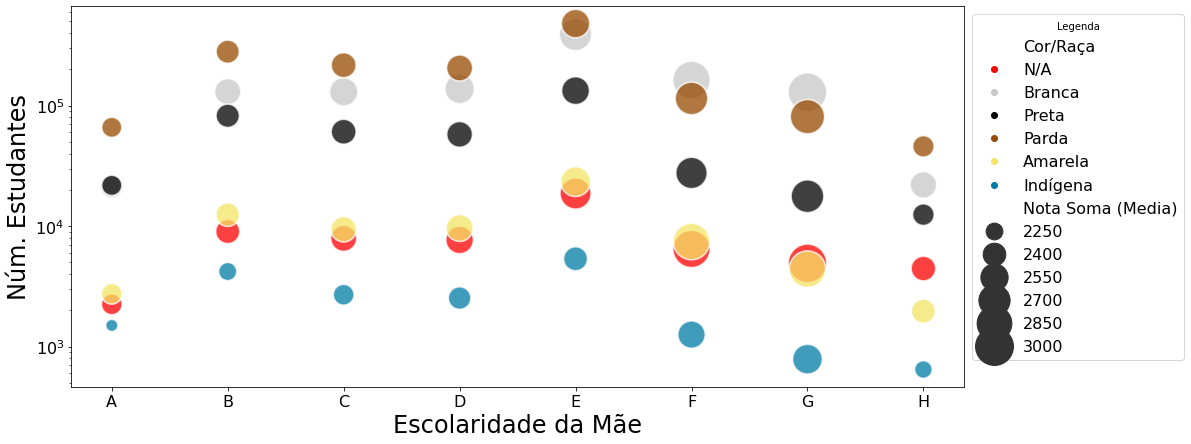

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# PLOT DATA
#--------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(16,7))

sns.scatterplot(x='Escolaridade da Mãe',
                size='Nota Soma (Media)',
                y='Núm. Estudantes',
                hue="Cor/Raça",
                data = df_nota_cor_maeEsc,
                sizes=(150,1500),
                alpha=0.75,
                palette=customPalette)
plt.xlabel('Escolaridade da Mãe')
plt.ylabel('Núm. Estudantes')
plt.yscale('log')
plt.legend(title='Legenda', bbox_to_anchor=(1, 1), loc='upper left',prop={'size': 16})

# DUMP DATAFRAME TO FREE MEMORY
df_nota_cor_maeEsc = None
gc.collect()

<a name="52"></a>
### A profissão da Mãe: retrato do papel social da mulher mãe

Vamos levar também em consideração outra pergunta do questionário socioeconômico:
> **_Q004: A partir da apresentação de algumas ocupações divididas em grupos ordenados, indique o grupo que contempla a ocupação mais próxima da ocupação da sua mãe ou da mulher responsável por você. (Se ela não estiver trabalhando, escolha uma ocupação pensando no último trabalho dela)._**
>
relacionado à profissão da mãe.  
Essa resposta é de múltipla escolha, e a Tabela abaixo resume as possíveis respostas ($6$ classes).

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# QUESTIONÁRIO SÓCIO ECONÔMICO: CATEGORIAS CORRESPONDENTES DA Q004 (GRUPO DA PROFISSÃO DA MÃE)
#--------------------------------------------------------------------------------------------------------------

df_profissao_mae = pd.DataFrame(zip(sorted(df0['Q004'].dropna().unique()),
[
'Grupo 1: Lavradora, agricultora sem empregados, bóia fria, criadora de animais (gado, porcos, galinhas, ovelhas, cavalos etc.), apicultora, pescadora, lenhadora, seringueira, extrativista.',
'Grupo 2: Diarista, empregada doméstica, cuidadora de idosos, babá, cozinheira (em casas particulares), motorista particular, jardineira, faxineira de empresas e prédios, vigilante, porteira, carteira, office-boy, vendedora, caixa, atendente de loja, auxiliar administrativa, recepcionista, servente de pedreiro, repositora de mercadoria.',
'Grupo 3: Padeira, cozinheira industrial ou em restaurantes, sapateira, costureira, joalheira, torneira mecânica, operadora de máquinas, soldadora, operária de fábrica, trabalhadora da mineração, pedreira, pintora, eletricista, encanadora, motorista, caminhoneira, taxista.',
'Grupo 4: Professora (de ensino fundamental ou médio, idioma, música, artes etc.), técnica (de enfermagem, contabilidade, eletrônica etc.), policial, militar de baixa patente (soldado, cabo, sargento), corretora de imóveis, supervisora, gerente, mestre de obras, pastora, microempresária (proprietária de empresa com menos de 10 empregados), pequena comerciante, pequena proprietária de terras, trabalhadora autônoma ou por conta própria.',
'Grupo 5: Médica, engenheira, dentista, psicóloga, economista, advogada, juíza, promotora, defensora, delegada, tenente, capitã, coronel, professora universitária, diretora em empresas públicas ou privadas, política, proprietária de empresas com mais de 10 empregados.',
'Não sei.'
]),columns=['Categoria','Profissão da Mãe'])

print(tabulate(df_profissao_mae.set_index('Categoria'), headers='keys'))

Categoria    Profissão da Mãe
-----------  -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
A            Grupo 1: Lavradora, agricultora sem empregados, bóia fria, criadora de animais (gado, porcos, galinhas, ovelhas, cavalos etc.), apicultora, pescadora, lenhadora, seringueira, extrativista.
B            Grupo 2: Diarista, empregada doméstica, cuidadora de idosos, babá, cozinheira (em casas particulares), motorista particular, jardineira, faxineira de empresas e prédios, vigilante, porteira, carteira, office-boy, vendedora, caixa, atendente de loja, auxiliar administrativa, recepcionista, servente de pe

Repetimos então uma análise similar à anterior.

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# QUERY AND PROCESS
#--------------------------------------------------------------------------------------------------------------
ano = '2019'

df_nota_cor_maeProf = df0.query('Ano=='+ano)[['nota_soma','TP_COR_RACA','Q004']].dropna()
df_nota_cor_maeProf = df_nota_cor_maeProf.groupby(["TP_COR_RACA",'Q004']).aggregate(['mean','count']).reset_index()
df_nota_cor_maeProf = pd.DataFrame(df_nota_cor_maeProf[[('Q004',''),('nota_soma','count'),('TP_COR_RACA',''),('nota_soma','mean')]].values,
            columns=['Profissão da Mãe','Núm. Estudantes', "Cor/Raça" ,'Nota Soma (Media)'])
df_nota_cor_maeProf['Cor/Raça'] = df_nota_cor_maeProf['Cor/Raça'].replace(dict_cor_raca)

E novamente a conclusão é similar:
- a última categoria (F) corresponde à declaração "Não sei", portanto não pense nela como uma tendência do que veio antes
- as profissões mais bem remuneradas, que exigem longos anos de estudo e nível superior de ensino, estão na categoria E
- note a inversão do volume a partir da categoria D e indo até E, passando a predominar o volume pessoas da cor/raça "Branca"
- note o aumento das bolhas (nota média) para todas as categorias de cor/raça ao entrar nas profissões dos grupos D e E

10284

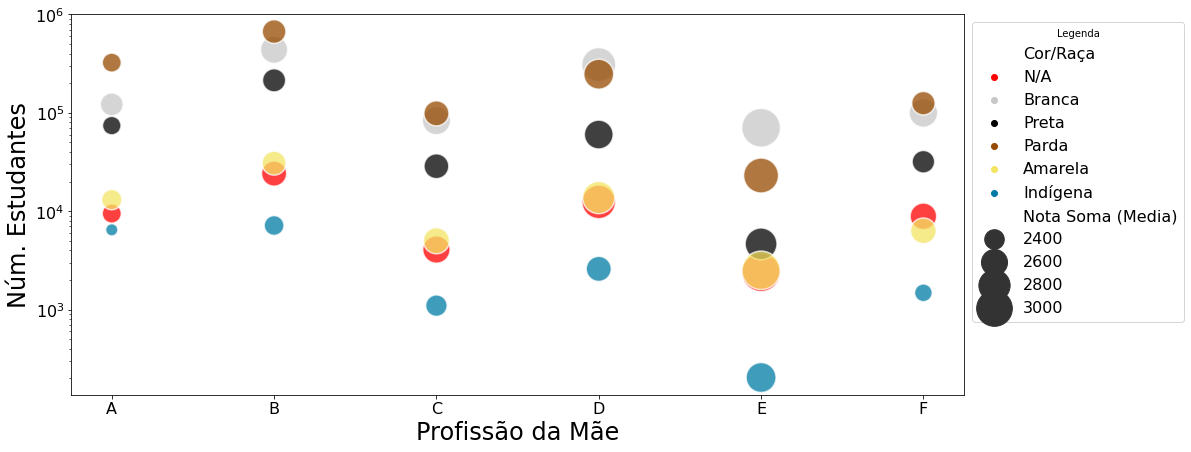

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# PLOT DATA
#--------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(16,7))

sns.scatterplot(x='Profissão da Mãe',
                size='Nota Soma (Media)',
                y='Núm. Estudantes',
                hue="Cor/Raça",
                data = df_nota_cor_maeProf,
                sizes=(150,1500),
                alpha=0.75,
                palette=customPalette)
plt.xlabel('Profissão da Mãe')
plt.ylabel('Núm. Estudantes')
plt.yscale('log')
plt.legend(title='Legenda', bbox_to_anchor=(1, 1), loc='upper left',prop={'size': 16})

# DUMP DATAFRAME TO FREE MEMORY
df_nota_cor_maeProf = None
gc.collect()

Podemos resumir essas últimas análise com algumas opiniões do autor:
- embora não tenha inserido aqui, fiz uma análise similar da influência do pai, e notei menor influência nas notas médias (embora a mesma inversão de volume ocorra)
- no Brasil, podemos buscar outros dados para corroborar que o papel da mulher (mãe) na criação e educação dos filhos é muito mais influente do que do homem (pai)
- o passado recente das últimas gerações claramente influencia no desempenho dos estudantes, pois sabe-se que o processo de escolarização também é influenciado pela família.

<a name="53"></a>
### Gravidez na Adolescência

Os dados parecem indicar que estudantes filhos de mães com alto grau de escolarização e profissões bem reconhecidas/remuneradas possuem notas médias mais altas.  
Mas, **como uma mulher mãe pode construir a sua carreira quando a gravidez acontece muito antes dela se profissionalizar?**  
Com certeza é um desafio muito maior!  
Também sabemos que pais adolescentes costumam abandonar seus filhos ou, em outros casos, serem excluídos e não responsabilizados pelo processo de criação dessas crianças.  
O fato do aborto não ser legalizado no Brasil também afeta a vida dessas adolescentes e jovens que engravidam muito cedo, sem planejamento.

O que isso tem a ver com os microdados do ENEM?  
Existem dois campos relacionados à gravidez, um para indicar se a candidata é gestante e outro para indicar se é lactante (a mãe que produz leite e amamenta).  
Vou fazer uma análise bem pontual aqui: **filtrando candidatas co menos de 24 anos, gestantes ou lactantes,** quero analisar suas notas médias e tipo de escola de origem.

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# QUERY AND PROCESS
#--------------------------------------------------------------------------------------------------------------
ano = '2019'

query_ano   = 'Ano=='+ano
query_F     = '(IN_GESTANTE==1 or IN_LACTANTE==1) and TP_SEXO=="F"'
query_idade = 'NU_IDADE <= 24' 
all_queries_gestantes = query_ano + ' and ' + query_F + ' and ' + query_idade
all_queries_F = query_ano + ' and ' + 'TP_SEXO=="F"' + ' and ' + query_idade

cols_interesse = ['NU_IDADE','TP_ESCOLA','nota_soma']

df_gestantes_1 = df0.query(all_queries_gestantes)[cols_interesse].dropna()
df_todas_F = df0.query(all_queries_F)[cols_interesse].dropna()

print(f'Todas as estudantes TP_SEXO=="F" (menos de 25 anos):  {len(df_todas_F)}')
print(f'Estudantes gestantes ou lactantes (menos de 25 anos): {len(df_gestantes_1)}')

nota_media_nao_gestantes = df0.query('(IN_GESTANTE==1 or IN_LACTANTE==1)')['nota_soma'].mean()
df_gestantes_1 = df_gestantes_1.groupby(['NU_IDADE','TP_ESCOLA'])['nota_soma'].agg(['mean','count']).reset_index()
#df_gestantes_1

print(f'Nota_soma (média) das estudantes não-gestantes e não-lactantes {nota_media_nao_gestantes}')

Todas as estudantes TP_SEXO=="F" (menos de 25 anos):  1499215
Estudantes gestantes ou lactantes (menos de 25 anos): 1131
Nota_soma (média) das estudantes não-gestantes e não-lactantes 2480.434212970782


Nesse processo, já identificamos o seguinte:
- dentre todas as estudantes  ``TP_SEXO=="F"`` (com menos de 25 anos), temos $1499215$ candidatas
- dessas, o número de gestantes ou lactantes é apenas 1131 (75 a cada 100 mil).  

Portanto, já vemos que a amostra é pequena.  
No gráfico abaixo, vemos que:
- o volume de estudantes (tamanho das bolhas) das escolas com tipo não declarado se distribui quase igualmente entre 19 e 24 anos
- o volume de estudantes de escolas públicas é maior entre 17 e 18 anos
- a minoria está na categoria de escolas particulares
- as média das notas das candidatas das escolas particulares está acima da nota média das estudantes não-gestantes e não-lactantes
- as média das notas das candidatas das escolas públicas está abaixo da nota média das estudantes não-gestantes e não-lactantes.



9791

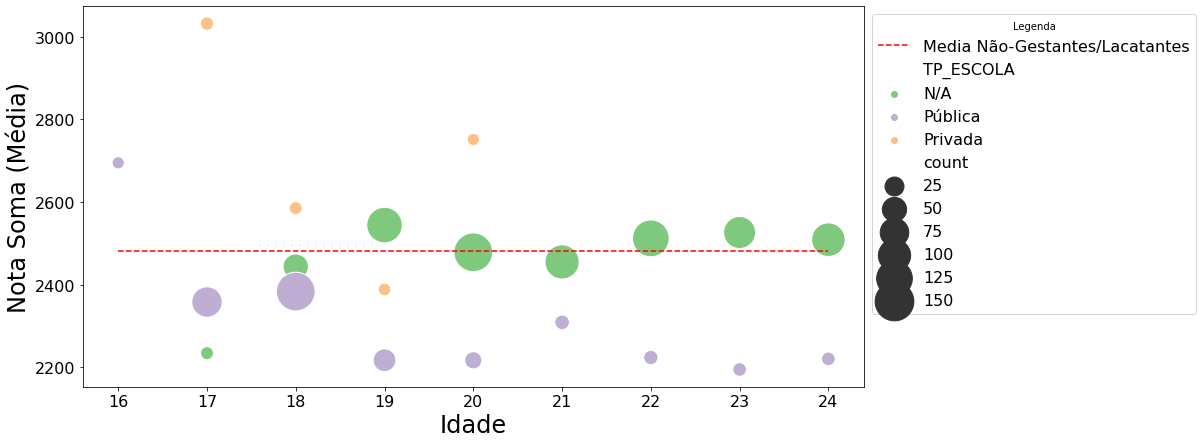

In [ ]:
#--------------------------------------------------------------------------------------------------------------
# PLOT DATA
#--------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(14,7))

df_gestantes_1 = df_gestantes_1.sort_values(by=['TP_ESCOLA','NU_IDADE'])
df_gestantes_1['TP_ESCOLA'] = df_gestantes_1['TP_ESCOLA'].replace(dict_tipo_escola) 

idades = df_gestantes_1['NU_IDADE'].unique().astype('int32').tolist()
plt.hlines(y=nota_media_nao_gestantes,xmin=min(idades),xmax=max(idades),color='r',linestyle='dashed',label='Media Não-Gestantes/Lacatantes')

sns.scatterplot(data=df_gestantes_1,x='NU_IDADE', y='mean', hue='TP_ESCOLA',size='count',sizes=(150,1500),palette='Accent')

plt.xlabel('Idade')
plt.ylabel('Nota Soma (Média)')
plt.legend(title='Legenda', bbox_to_anchor=(1, 1), loc='upper left',prop={'size': 16})

# DUMP DATAFRAME TO FREE MEMORY
df_gestantes_1 = None
df_todas_F     = None
gc.collect()

<a name="6"></a>
# 6. "O Óbvio só é Óbvio Quando é Dito".

Mas e aí, afinal, dá pra concluir alguma coisa dessas análises?  
Claramente, os dados do ENEM não podem ser analisados de forma isolada, sem contexto.  
Lembre também que não fiz testes estatísticos mais avançados e medidas de correlações entre variáveis. Foi apenas uma análise exploratória pra obter alguns _insights_. <br>

O que podemos dizer é que esses dados estão refletindo muitas coisas que parecem ser senso comum (pelo menos pra quem tem bom senso).  
E qual a importância de revelar, através dos dados, o que já é "óbvio" para o "senso comum"?  

Bem, estamos em $2020$, e muitas pessoas estão confrontando a ciência e os fatos estabelecidos com notícias falsas e teorias da conspiração. 
Isso é bastante perigoso, pois através do discurso e em posições de poder, essas pessoas acabam distorcendo a realidade e espalhando desinformação para a população.  
Num país como o Brasil, cheio de desigualdades, espalhar desinformação para a população mais leiga e vulnerável é praticamente um crime!  

Portanto, às vezez o papel da ciência de dados pode ser apenas corroborar a realidade com um método mais científico, analítico e objetivo.  
E os dados do ENEM parecem refletir muitas coisas da realidade conhecida pelo brasileiro.  

Cabe a você agora utilizar esses dados para lutar por soluções para os problemas evidenciados. :)